In [1]:
import pandas as pd
pd.set_option('display.expand_frame_repr', False)

import matplotlib
import matplotlib.pyplot as plt
font = {'size' : 20}
matplotlib.rc('font', **font)

import seaborn as sns

from pylab import rcParams
rcParams["figure.figsize"] = 30,16

from collections import OrderedDict

import datetime as dt
from datetime import date
from datetime import datetime

import sklearn
from sklearn import metrics
from sklearn.model_selection import KFold

from sklearn.preprocessing import MinMaxScaler
import joblib

import numpy as np
np.random.seed(0)
import scipy

import datetime as dt
from datetime import date

import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Activation, InputLayer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.insert(0, "../")
import functions

#Funktion für RMSE erstellen
from keras import backend as K
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

## <font size="7">LSTM-LSTM-1</font><a class="anchor" id="lstm-lstm-1"></a>

<font size="5">Das Netz lässt sich durch eine weitere LSTM-Schicht vergrößern. Dafür wird zunächst zur ersten Schicht aus 32 Neuronen eine weitere Schicht mit 64 Neuronen hinzugefügt, um mehr Potenzial für Generalisierungen zu bieten.<font>

### <font size="5">Modell und Parameter</font>

In [2]:
#Hyperparameter
epochs = 100
batch_size = 8

window_size = 14

def model_creation():
    
    #Modell erstellen
    model = Sequential()
    model.add(InputLayer(input_shape=(window_size, 4)))
    
    model.add(LSTM(units=32, return_sequences=True, activation="tanh"))
    model.add(LSTM(units=64, return_sequences=False, activation="tanh"))
    
    model.add(Dense(units=1))

    adam = Adam(learning_rate=0.0005)

    model.compile(loss=root_mean_squared_error, optimizer=adam)
    
    return model

### <font size="5">Daten laden</font>

In [3]:
#Unskalierte Daten für Analysen laden
df_unscaled = pd.read_csv("../3-Data Preparation/data.csv", index_col=0, parse_dates=True)
df_unscaled.index.freq = "D"

y_test_true = df_unscaled["verbrauch"]["2021-01-01":]
y_train_true = df_unscaled["verbrauch"][window_size:2192]

#Skalierte Daten für Modellierung laden
df_scaled = pd.read_csv("../3-Data Preparation/data_scaled.csv", index_col=0, parse_dates=True)
df_scaled.index.freq = "D"

#Aufteilung X (Merkmale) und y (Ziel)
X = df_scaled[["verbrauch","arbeitstag","temperatur","tagesstunden"]]
#Stromverbrauch wird bei X um eine Stelle nach vorne verschoben, daher entfällt der 01.01.2015
X["arbeitstag"] = X["arbeitstag"].shift(-1)
X["temperatur"] = X["temperatur"].shift(-1)
X["tagesstunden"] = X["tagesstunden"].shift(-1)
X = X[:2556]

y = df_scaled["verbrauch"]

#Aufteilung der Daten in Zeitfenster
def restructure_data(px, py, window_size):
    
    X_, y_ = [], []
    
    idx_range = range(len(px) - (window_size) + 1)
    
    for idx in idx_range:
        X_.append(px[idx:idx+window_size])
        y_.append(py[idx+window_size])
        
    X_ = np.array(X_)
    y_ = np.array(y_)
    
    return X_, y_

X_windows, y_windows = restructure_data(X, y, window_size)

#Aufteilung in Trainings-, Validierungs- und Testdaten
split_by = 2557 - 365 - window_size

X_train = X_windows[:split_by]
y_train = y_windows[:split_by]

X_test = X_windows[split_by:]
y_test = y_windows[split_by:]

### <font size="5">Training</font>

In [4]:
#Kreuzvalidierung erstellen
kfold = KFold(n_splits=5, shuffle=True, random_state=0)

#DataFrames für History und Metriken
df_history = pd.DataFrame()
df_history.index.name = "Epoch"

df_metrics = pd.DataFrame(columns=["Testdaten", "Trainingsdaten", "Validierungsdaten"])
df_metrics.index.name = "Split"

iteration = 1

scaler_target = joblib.load("../3-Data Preparation/scaler_endog.save")

#Kreuzvalidierung
for train_index, validation_index in kfold.split(X_train, y_train):
    
    print(iteration, "-", end="\t")
    
    #Modell erstellen
    model = model_creation()
    
    #Modell trainieren
    history = model.fit(x=X_train[train_index], y=y_train[train_index], epochs=epochs, batch_size=batch_size, validation_data=(X_train[validation_index], y_train[validation_index]), verbose=0)
    
    #Ergebnisse speichern
    df_history[str(iteration) + "_train_loss"] = pd.DataFrame(data=(scaler_target.inverse_transform(np.array(history.history["loss"]).reshape(-1, 1)) - 102469)).squeeze()
    df_history[str(iteration) + "_validation_loss"] = pd.DataFrame(data=(scaler_target.inverse_transform(np.array(history.history["val_loss"]).reshape(-1, 1)) - 102469)).squeeze()
    
    #Vorhersagen für Test-, Trainings- und Validierungsdaten
    preds_test = scaler_target.inverse_transform(model.predict(X_test).reshape(-1, 1))
    preds_train = scaler_target.inverse_transform(model.predict(X_train[train_index]).reshape(-1, 1))
    preds_validation = scaler_target.inverse_transform(model.predict(X_train[validation_index]).reshape(-1, 1))
    
    df_metrics.loc[iteration] = [round(metrics.mean_absolute_percentage_error(y_test_true, preds_test) * 100, 2),
                                 round(metrics.mean_absolute_percentage_error(y_train_true[train_index], preds_train) * 100, 2),
                                 round(metrics.mean_absolute_percentage_error(y_train_true[validation_index], preds_validation) * 100, 2)]
    
    iteration = iteration + 1

#Durchschnittswerte bei History und Metriken berechnen
df_history["train_loss"] = (df_history["1_train_loss"] + df_history["2_train_loss"] + df_history["3_train_loss"] + df_history["4_train_loss"] + df_history["5_train_loss"]) / 5
df_history["validation_loss"] = (df_history["1_validation_loss"] + df_history["2_validation_loss"] + df_history["3_validation_loss"] + df_history["4_validation_loss"] + df_history["5_validation_loss"]) / 5

df_metrics.loc["Average"] = [round(df_metrics["Testdaten"].mean(), 2),
                             round(df_metrics["Trainingsdaten"].mean(), 2),
                             round(df_metrics["Validierungsdaten"].mean(), 2)]

1 -	2 -	3 -	4 -	5 -	

### <font size="5">Auswertung des Trainings</font>

         Testdaten  Trainingsdaten  Validierungsdaten
Split                                                
1             2.35            1.50               1.70
2             2.54            1.55               1.85
3             2.05            1.57               1.80
4             2.60            1.59               1.80
5             2.17            1.54               1.71
Average       2.34            1.55               1.77





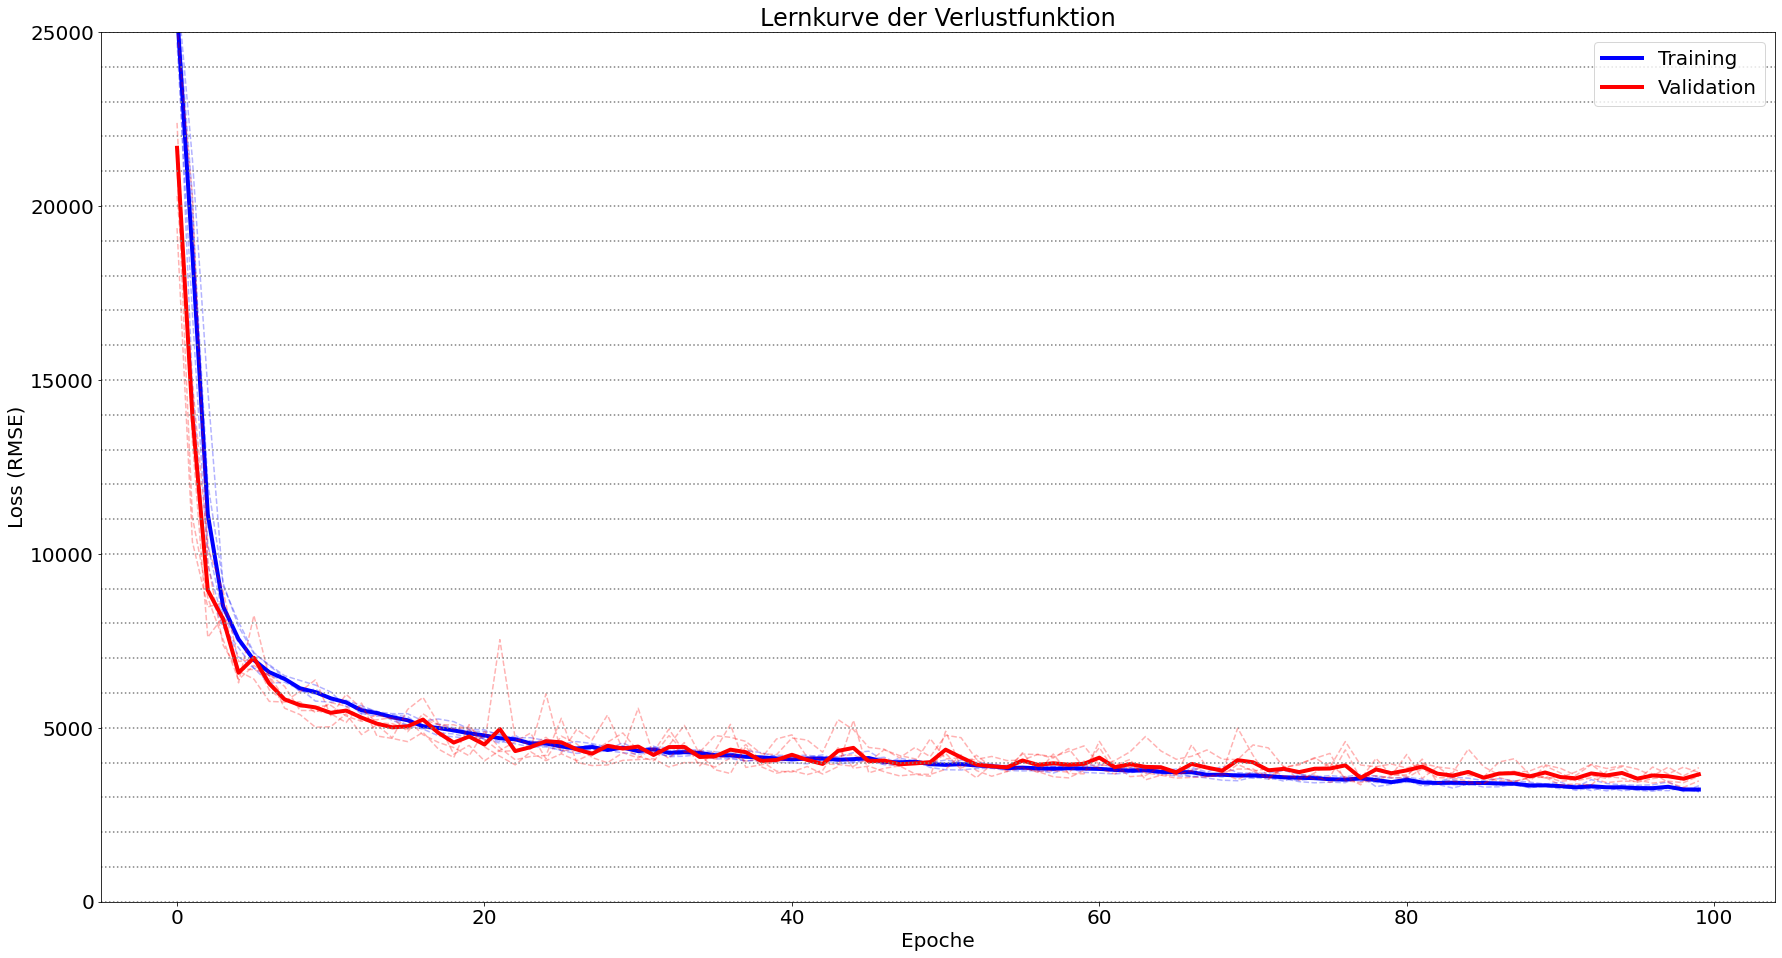

In [8]:
#Training auswerten (Metriken und Lernkurve)
functions.evaluate_training(df_metrics, df_history, 25000)

<font size="5">
Die Lernkurve deutet wie schon beim einschichtigen LSTM auf eine zu hohe Lernrate hin. Die Konvergenz auf den Testdaten setzt in etwa nach 70 Epochen ein, ab dann führt weiteres Training zu Überanpassungen.
</font>
<br><br>
<font size="5">
Das Modell hat sich im Vergleich zum einschichtigen LSTM-Netz nicht verbessert. Allerdings werden die Trainingsdaten besser erkannt, was auf eine Überanpassung hindeutet.
</font>

### <font size="5">Test</font>

In [6]:
#Finales Modell erstellen
model = model_creation()

#Finales Modell trainieren
history = model.fit(x=X_train, y=y_train, epochs=epochs, batch_size=batch_size, use_multiprocessing=True)

Epoch 1/100
273/273 [==============================] - 5s 9ms/step - loss: 0.1927
Epoch 2/100
273/273 [==============================] - 2s 8ms/step - loss: 0.1172
Epoch 3/100
273/273 [==============================] - 2s 8ms/step - loss: 0.0700
Epoch 4/100
273/273 [==============================] - 2s 8ms/step - loss: 0.0562
Epoch 5/100
273/273 [==============================] - 2s 7ms/step - loss: 0.0539
Epoch 6/100
273/273 [==============================] - 2s 8ms/step - loss: 0.0504
Epoch 7/100
273/273 [==============================] - 2s 8ms/step - loss: 0.0472
Epoch 8/100
273/273 [==============================] - 2s 8ms/step - loss: 0.0455
Epoch 9/100
273/273 [==============================] - 2s 8ms/step - loss: 0.0453
Epoch 10/100
273/273 [==============================] - 2s 7ms/step - loss: 0.0426
Epoch 11/100
273/273 [==============================] - 2s 8ms/step - loss: 0.0412
Epoch 12/100
273/273 [==============================] - 2s 7ms/step - loss: 0.0414
Epoch 13/100


       Testdaten Trainingsdaten
R2          0.96           0.98
MAE       4139.0         2592.0
MSE   30218619.0     12450978.0
RMSE      5497.0         3529.0
                               
MAPE      2.48 %         1.59 %


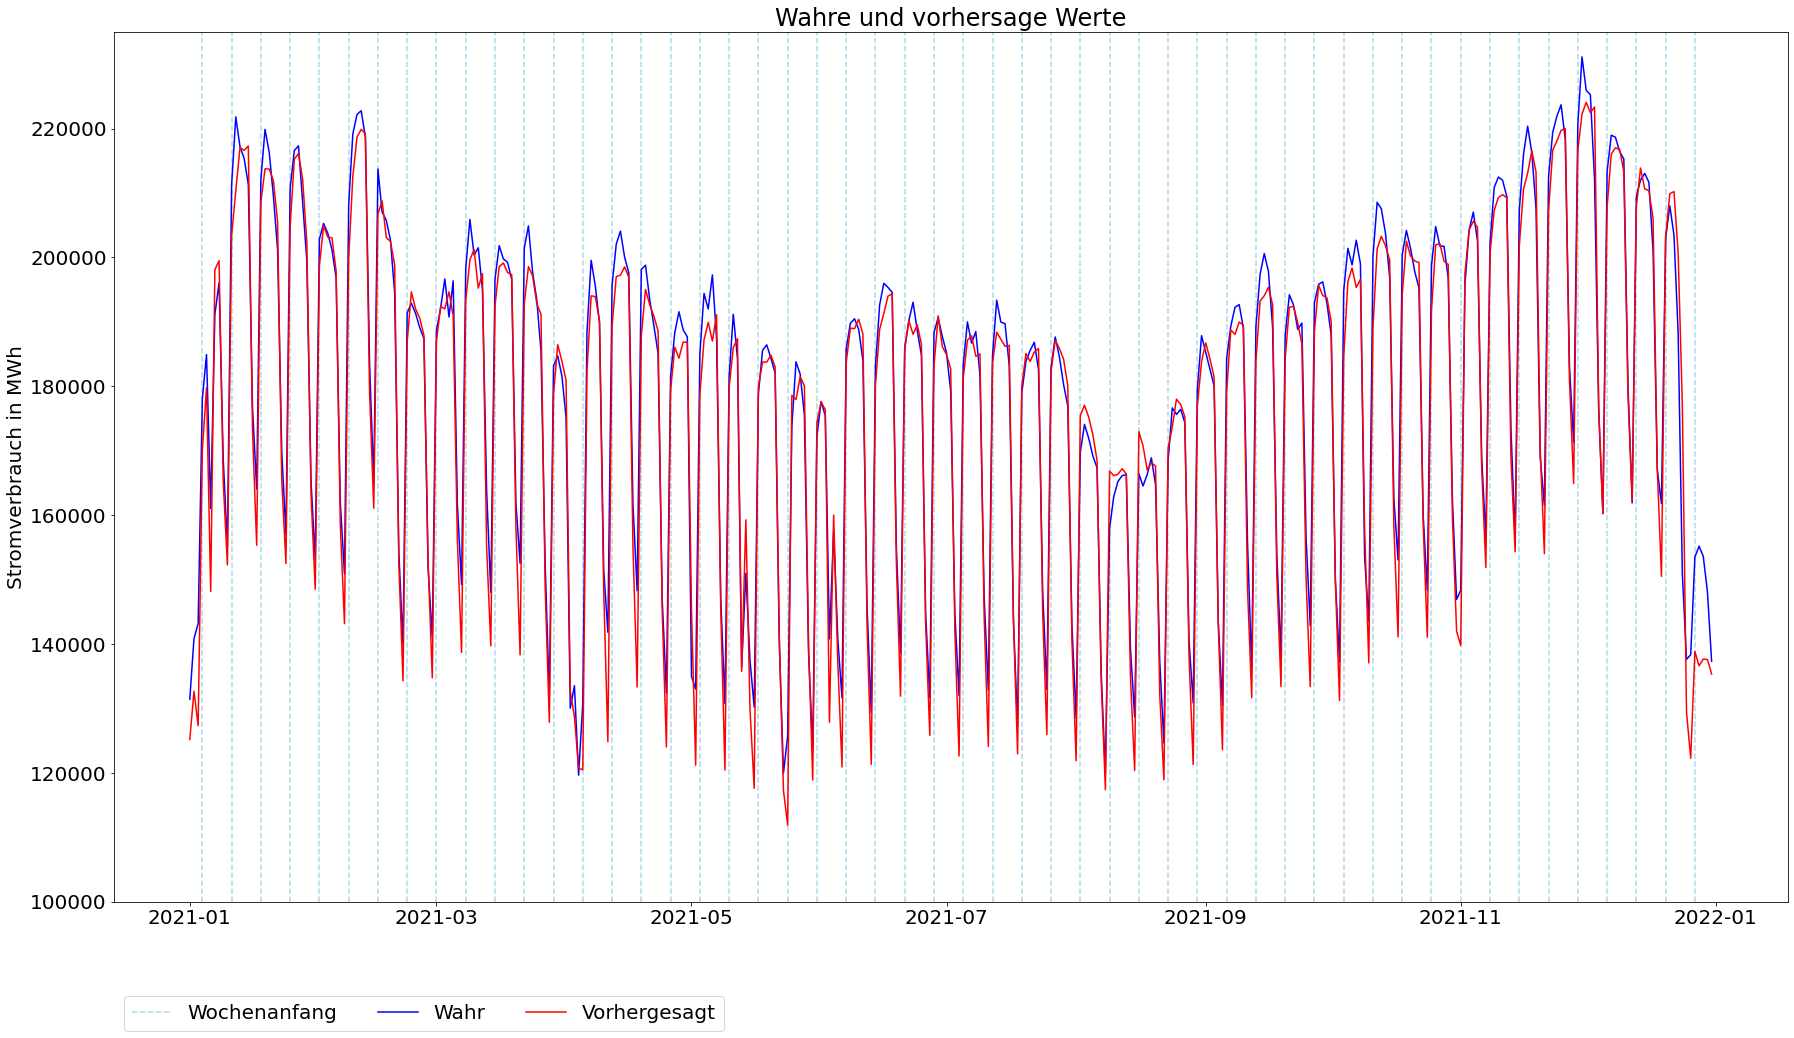

In [7]:
#Vorhersagen erzeugen
scaled_preds_test = model.predict(X_test)
scaled_preds_train = model.predict(X_train)

functions.custom_metrics_lstm(y_test_true, scaled_preds_test, y_train_true, scaled_preds_train)

## <font size="7">LSTM-LSTM-2</font><a class="anchor" id="lstm-lstm-2"></a>

<font size="5">In diesem Schritt wird das LSTM-Netz durch mehr Neuronen in der ersten Schicht erweitert.<font>

### <font size="5">Modell und Parameter</font>

In [2]:
#Hyperparameter
epochs = 100
batch_size = 8

window_size = 14

def model_creation():
    
    #Modell erstellen
    model = Sequential()
    model.add(InputLayer(input_shape=(window_size, 4)))
    
    model.add(LSTM(units=64, return_sequences=True, activation="tanh"))
    model.add(LSTM(units=64, return_sequences=False, activation="tanh"))
    
    model.add(Dense(units=1))

    adam = Adam(learning_rate=0.0005)

    model.compile(loss=root_mean_squared_error, optimizer=adam)
    
    return model

### <font size="5">Daten laden</font>

In [3]:
#Unskalierte Daten für Analysen laden
df_unscaled = pd.read_csv("../3-Data Preparation/data.csv", index_col=0, parse_dates=True)
df_unscaled.index.freq = "D"

y_test_true = df_unscaled["verbrauch"]["2021-01-01":]
y_train_true = df_unscaled["verbrauch"][window_size:2192]

#Skalierte Daten für Modellierung laden
df_scaled = pd.read_csv("../3-Data Preparation/data_scaled.csv", index_col=0, parse_dates=True)
df_scaled.index.freq = "D"

#Aufteilung X (Merkmale) und y (Ziel)
X = df_scaled[["verbrauch","arbeitstag","temperatur","tagesstunden"]]
#Stromverbrauch wird bei X um eine Stelle nach vorne verschoben, daher entfällt der 01.01.2015
X["arbeitstag"] = X["arbeitstag"].shift(-1)
X["temperatur"] = X["temperatur"].shift(-1)
X["tagesstunden"] = X["tagesstunden"].shift(-1)
X = X[:2556]

y = df_scaled["verbrauch"]

#Aufteilung der Daten in Zeitfenster
def restructure_data(px, py, window_size):
    
    X_, y_ = [], []
    
    idx_range = range(len(px) - (window_size) + 1)
    
    for idx in idx_range:
        X_.append(px[idx:idx+window_size])
        y_.append(py[idx+window_size])
        
    X_ = np.array(X_)
    y_ = np.array(y_)
    
    return X_, y_

X_windows, y_windows = restructure_data(X, y, window_size)

#Aufteilung in Trainings-, Validierungs- und Testdaten
split_by = 2557 - 365 - window_size

X_train = X_windows[:split_by]
y_train = y_windows[:split_by]

X_test = X_windows[split_by:]
y_test = y_windows[split_by:]

### <font size="5">Training</font>

In [4]:
#Kreuzvalidierung erstellen
kfold = KFold(n_splits=5, shuffle=True, random_state=0)

#DataFrames für History und Metriken
df_history = pd.DataFrame()
df_history.index.name = "Epoch"

df_metrics = pd.DataFrame(columns=["Testdaten", "Trainingsdaten", "Validierungsdaten"])
df_metrics.index.name = "Split"

iteration = 1

scaler_target = joblib.load("../3-Data Preparation/scaler_endog.save")

#Kreuzvalidierung
for train_index, validation_index in kfold.split(X_train, y_train):
    
    print(iteration, "-", end="\t")
    
    #Modell erstellen
    model = model_creation()
    
    #Modell trainieren
    history = model.fit(x=X_train[train_index], y=y_train[train_index], epochs=epochs, batch_size=batch_size, validation_data=(X_train[validation_index], y_train[validation_index]), verbose=0)
    
    #Ergebnisse speichern
    df_history[str(iteration) + "_train_loss"] = pd.DataFrame(data=(scaler_target.inverse_transform(np.array(history.history["loss"]).reshape(-1, 1)) - 102469)).squeeze()
    df_history[str(iteration) + "_validation_loss"] = pd.DataFrame(data=(scaler_target.inverse_transform(np.array(history.history["val_loss"]).reshape(-1, 1)) - 102469)).squeeze()
    
    #Vorhersagen für Test-, Trainings- und Validierungsdaten
    preds_test = scaler_target.inverse_transform(model.predict(X_test).reshape(-1, 1))
    preds_train = scaler_target.inverse_transform(model.predict(X_train[train_index]).reshape(-1, 1))
    preds_validation = scaler_target.inverse_transform(model.predict(X_train[validation_index]).reshape(-1, 1))
    
    df_metrics.loc[iteration] = [round(metrics.mean_absolute_percentage_error(y_test_true, preds_test) * 100, 2),
                                 round(metrics.mean_absolute_percentage_error(y_train_true[train_index], preds_train) * 100, 2),
                                 round(metrics.mean_absolute_percentage_error(y_train_true[validation_index], preds_validation) * 100, 2)]
    
    iteration = iteration + 1

#Durchschnittswerte bei History und Metriken berechnen
df_history["train_loss"] = (df_history["1_train_loss"] + df_history["2_train_loss"] + df_history["3_train_loss"] + df_history["4_train_loss"] + df_history["5_train_loss"]) / 5
df_history["validation_loss"] = (df_history["1_validation_loss"] + df_history["2_validation_loss"] + df_history["3_validation_loss"] + df_history["4_validation_loss"] + df_history["5_validation_loss"]) / 5

df_metrics.loc["Average"] = [round(df_metrics["Testdaten"].mean(), 2),
                             round(df_metrics["Trainingsdaten"].mean(), 2),
                             round(df_metrics["Validierungsdaten"].mean(), 2)]

1 -	2 -	3 -	4 -	5 -	

### <font size="5">Auswertung des Trainings</font>

         Testdaten  Trainingsdaten  Validierungsdaten
Split                                                
1             2.21            1.66               1.81
2             2.24            1.40               1.62
3             2.59            1.44               1.70
4             2.95            1.63               1.95
5             2.24            1.47               1.59
Average       2.45            1.52               1.73





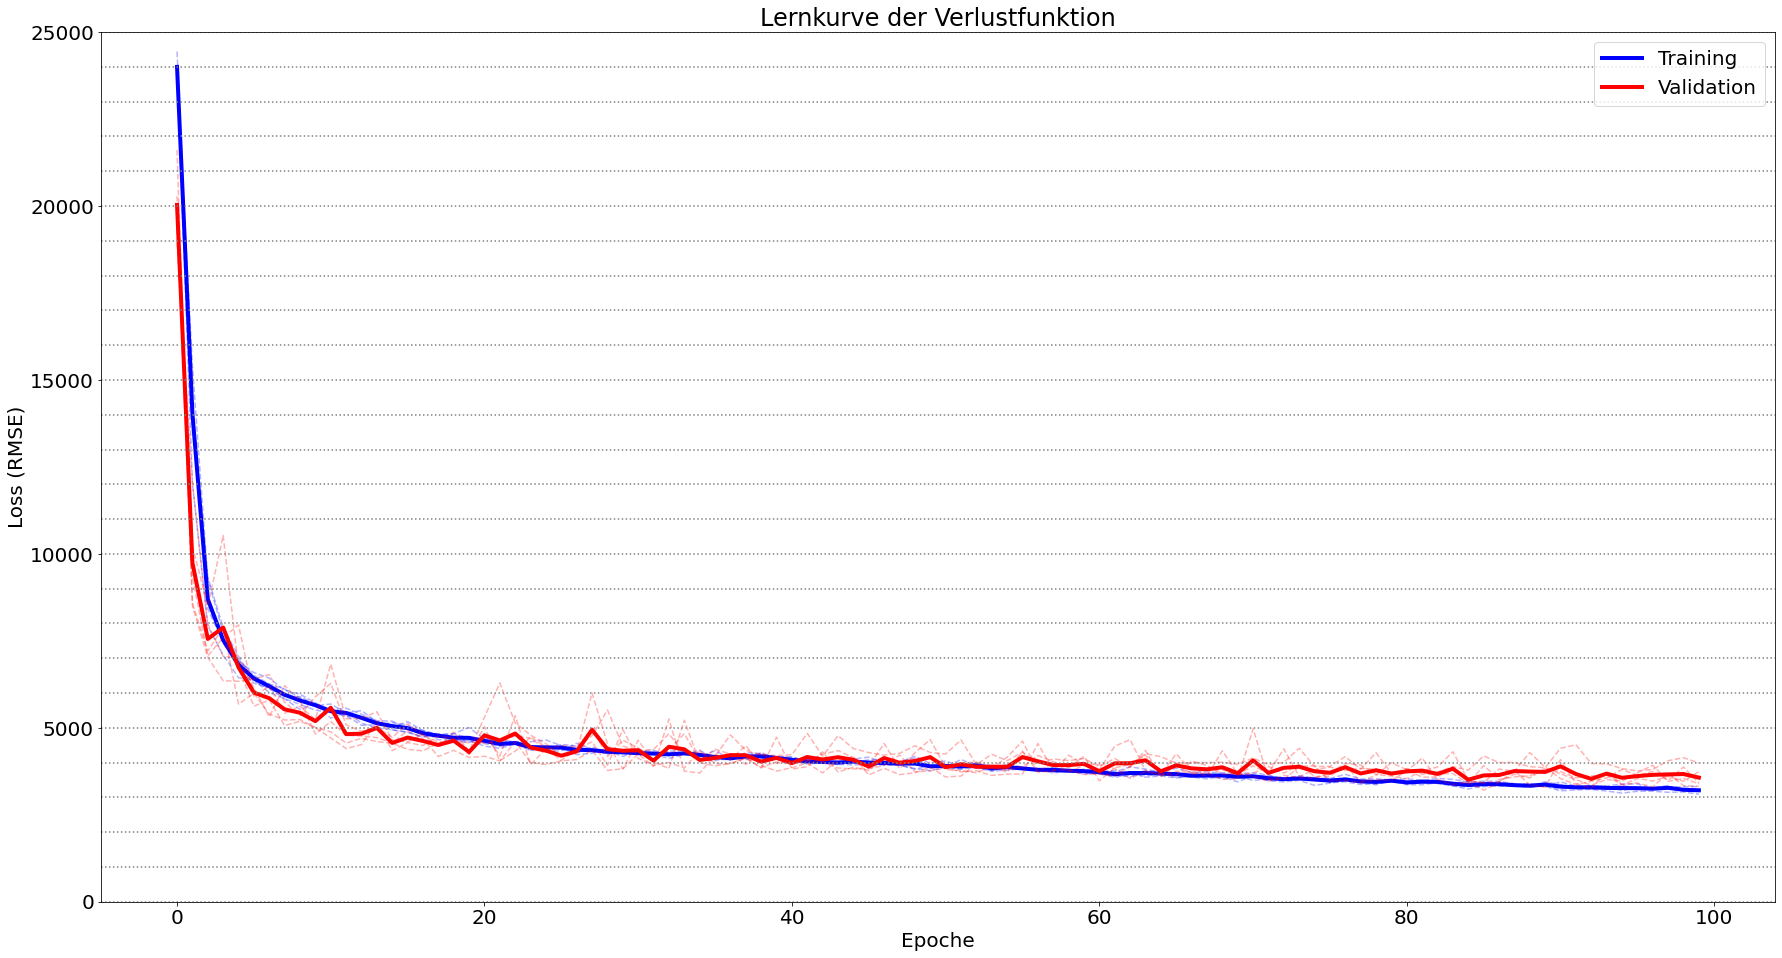

In [5]:
#Training auswerten (Metriken und Lernkurve)
functions.evaluate_training(df_metrics, df_history, 25000)

<font size="5">
Die Lernkurve deutet wie schon beim einschichtigen LSTM auf eine zu hohe Lernrate hin. Die Konvergenz auf den Testdaten setzt in etwa nach 70 Epochen ein, ab dann führt weiteres Training zu Überanpassungen.
</font>
<br><br>
<font size="5">
Die zusätzlichen Neuronen bringen keinen weiteren Nutzen. Die Metriken verbessern sich kaum, die Testdaten werden während der Kreuzvalidierung sogar schlechter erkannt. Daher ist von weiteren Vergrößerungen abzusehen. Stattdessen sollte noch einmal die Lernrate optimiert werden.
</font>


### <font size="5">Test</font>

In [6]:
#Finales Modell erstellen
model = model_creation()

#Finales Modell trainieren
history = model.fit(x=X_train, y=y_train, epochs=epochs, batch_size=batch_size, use_multiprocessing=True)

Epoch 1/100
273/273 [==============================] - 5s 8ms/step - loss: 0.1743
Epoch 2/100
273/273 [==============================] - 2s 8ms/step - loss: 0.0816
Epoch 3/100
273/273 [==============================] - 2s 8ms/step - loss: 0.0592
Epoch 4/100
273/273 [==============================] - 2s 8ms/step - loss: 0.0544
Epoch 5/100
273/273 [==============================] - 2s 8ms/step - loss: 0.0497
Epoch 6/100
273/273 [==============================] - 2s 8ms/step - loss: 0.0471
Epoch 7/100
273/273 [==============================] - 2s 8ms/step - loss: 0.0442
Epoch 8/100
273/273 [==============================] - 2s 8ms/step - loss: 0.0431
Epoch 9/100
273/273 [==============================] - 2s 8ms/step - loss: 0.0426
Epoch 10/100
273/273 [==============================] - 2s 8ms/step - loss: 0.0399
Epoch 11/100
273/273 [==============================] - 2s 8ms/step - loss: 0.0412
Epoch 12/100
273/273 [==============================] - 2s 8ms/step - loss: 0.0398
Epoch 13/100


       Testdaten Trainingsdaten
R2          0.96           0.98
MAE       3905.0         2449.0
MSE   25934455.0     11549078.0
RMSE      5093.0         3398.0
                               
MAPE      2.34 %          1.5 %


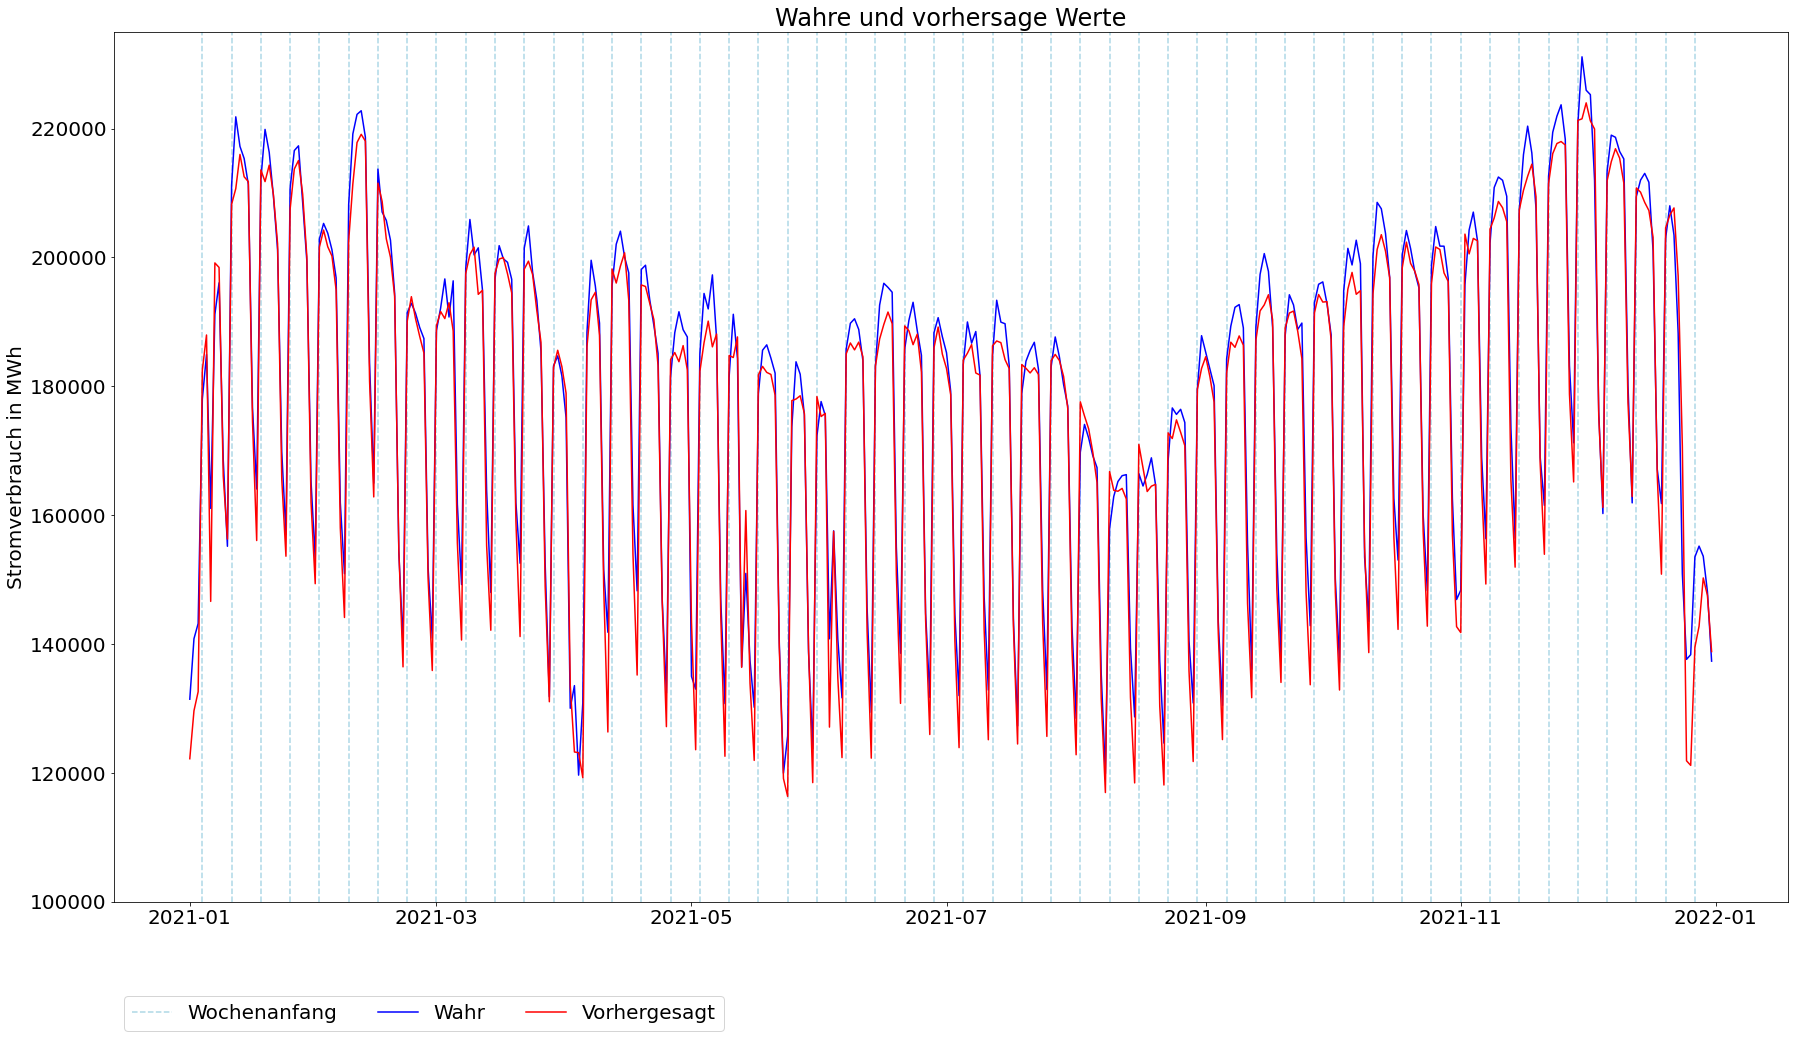

In [7]:
#Vorhersagen erzeugen
scaled_preds_test = model.predict(X_test)
scaled_preds_train = model.predict(X_train)

functions.custom_metrics_lstm(y_test_true, scaled_preds_test, y_train_true, scaled_preds_train)

## <font size="7">LSTM-LSTM-3</font><a class="anchor" id="lstm-lstm-3"></a>

<font size="5">Da der Verlauf der Lernkurve immer noch durch eine zu hohe Lernrate begründet sein könnte, wird nun statt 0,0005 eine niedrigere Rate von 0,0001 verwendet.<font>

### <font size="5">Modell und Parameter</font>

In [2]:
#Hyperparameter
epochs = 100
batch_size = 8

window_size = 14

def model_creation():
    
    #Modell erstellen
    model = Sequential()
    model.add(InputLayer(input_shape=(window_size, 4)))
    
    model.add(LSTM(units=32, return_sequences=True, activation="tanh"))
    model.add(LSTM(units=64, return_sequences=False, activation="tanh"))
    
    model.add(Dense(units=1))

    adam = Adam(learning_rate=0.0001)

    model.compile(loss=root_mean_squared_error, optimizer=adam)
    
    return model

### <font size="5">Daten laden</font>

In [3]:
#Unskalierte Daten für Analysen laden
df_unscaled = pd.read_csv("../3-Data Preparation/data.csv", index_col=0, parse_dates=True)
df_unscaled.index.freq = "D"

y_test_true = df_unscaled["verbrauch"]["2021-01-01":]
y_train_true = df_unscaled["verbrauch"][window_size:2192]

#Skalierte Daten für Modellierung laden
df_scaled = pd.read_csv("../3-Data Preparation/data_scaled.csv", index_col=0, parse_dates=True)
df_scaled.index.freq = "D"

#Aufteilung X (Merkmale) und y (Ziel)
X = df_scaled[["verbrauch","arbeitstag","temperatur","tagesstunden"]]
#Stromverbrauch wird bei X um eine Stelle nach vorne verschoben, daher entfällt der 01.01.2015
X["arbeitstag"] = X["arbeitstag"].shift(-1)
X["temperatur"] = X["temperatur"].shift(-1)
X["tagesstunden"] = X["tagesstunden"].shift(-1)
X = X[:2556]

y = df_scaled["verbrauch"]

#Aufteilung der Daten in Zeitfenster
def restructure_data(px, py, window_size):
    
    X_, y_ = [], []
    
    idx_range = range(len(px) - (window_size) + 1)
    
    for idx in idx_range:
        X_.append(px[idx:idx+window_size])
        y_.append(py[idx+window_size])
        
    X_ = np.array(X_)
    y_ = np.array(y_)
    
    return X_, y_

X_windows, y_windows = restructure_data(X, y, window_size)

#Aufteilung in Trainings-, Validierungs- und Testdaten
split_by = 2557 - 365 - window_size

X_train = X_windows[:split_by]
y_train = y_windows[:split_by]

X_test = X_windows[split_by:]
y_test = y_windows[split_by:]

### <font size="5">Training</font>

In [4]:
#Kreuzvalidierung erstellen
kfold = KFold(n_splits=5, shuffle=True, random_state=0)

#DataFrames für History und Metriken
df_history = pd.DataFrame()
df_history.index.name = "Epoch"

df_metrics = pd.DataFrame(columns=["Testdaten", "Trainingsdaten", "Validierungsdaten"])
df_metrics.index.name = "Split"

iteration = 1

scaler_target = joblib.load("../3-Data Preparation/scaler_endog.save")

#Kreuzvalidierung
for train_index, validation_index in kfold.split(X_train, y_train):
    
    print(iteration, "-", end="\t")
    
    #Modell erstellen
    model = model_creation()
    
    #Modell trainieren
    history = model.fit(x=X_train[train_index], y=y_train[train_index], epochs=epochs, batch_size=batch_size, validation_data=(X_train[validation_index], y_train[validation_index]), verbose=0)
    
    #Ergebnisse speichern
    df_history[str(iteration) + "_train_loss"] = pd.DataFrame(data=(scaler_target.inverse_transform(np.array(history.history["loss"]).reshape(-1, 1)) - 102469)).squeeze()
    df_history[str(iteration) + "_validation_loss"] = pd.DataFrame(data=(scaler_target.inverse_transform(np.array(history.history["val_loss"]).reshape(-1, 1)) - 102469)).squeeze()
    
    #Vorhersagen für Test-, Trainings- und Validierungsdaten
    preds_test = scaler_target.inverse_transform(model.predict(X_test).reshape(-1, 1))
    preds_train = scaler_target.inverse_transform(model.predict(X_train[train_index]).reshape(-1, 1))
    preds_validation = scaler_target.inverse_transform(model.predict(X_train[validation_index]).reshape(-1, 1))
    
    df_metrics.loc[iteration] = [round(metrics.mean_absolute_percentage_error(y_test_true, preds_test) * 100, 2),
                                 round(metrics.mean_absolute_percentage_error(y_train_true[train_index], preds_train) * 100, 2),
                                 round(metrics.mean_absolute_percentage_error(y_train_true[validation_index], preds_validation) * 100, 2)]
    
    iteration = iteration + 1

#Durchschnittswerte bei History und Metriken berechnen
df_history["train_loss"] = (df_history["1_train_loss"] + df_history["2_train_loss"] + df_history["3_train_loss"] + df_history["4_train_loss"] + df_history["5_train_loss"]) / 5
df_history["validation_loss"] = (df_history["1_validation_loss"] + df_history["2_validation_loss"] + df_history["3_validation_loss"] + df_history["4_validation_loss"] + df_history["5_validation_loss"]) / 5

df_metrics.loc["Average"] = [round(df_metrics["Testdaten"].mean(), 2),
                             round(df_metrics["Trainingsdaten"].mean(), 2),
                             round(df_metrics["Validierungsdaten"].mean(), 2)]

1 -	2 -	3 -	4 -	5 -	

### <font size="5">Auswertung des Trainings</font>

         Testdaten  Trainingsdaten  Validierungsdaten
Split                                                
1             2.53            2.12               2.18
2             2.53            1.90               1.90
3             2.32            2.04               2.21
4             2.68            1.96               2.20
5             2.50            2.16               2.09
Average       2.51            2.04               2.12





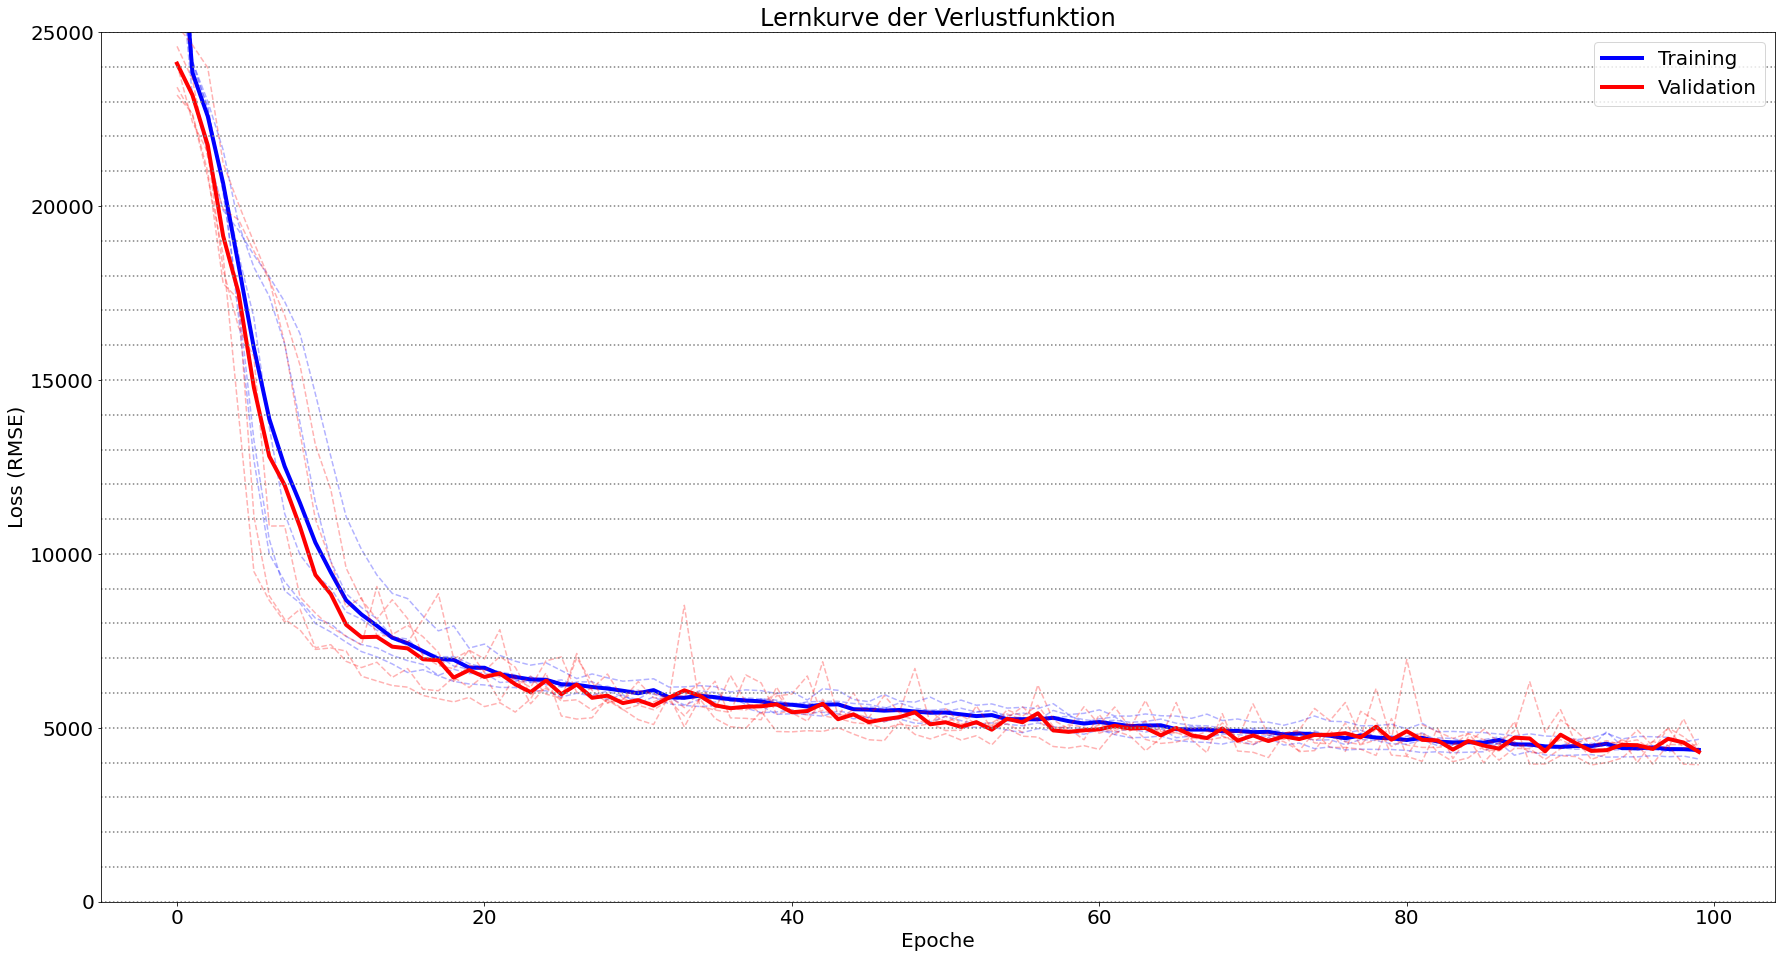

In [5]:
#Training auswerten (Metriken und Lernkurve)
functions.evaluate_training(df_metrics, df_history, 25000)

<font size="5">
Die Lernkurve verläuft allerdings trotzdem fast gleich, nur dass sich das Modell etwas zu verschlechtern scheint.
</font>
<br><br>
<font size="5">
An den Metriken ist zu erkennen, dass das Modell wie auch schon bei vorherigen Modellen bei einer Lernrate von 0,0001 zu Unteranpassungen neigt. Da die Lernkurve allerdings nach etwa 100 Epochen mit der Konvergenz beginnt, ist davon auszugehen, dass weitere Epochen das Modell nicht mehr ausreichend verbessern.
</font>


### <font size="5">Test</font>

In [6]:
#Finales Modell erstellen
model = model_creation()

#Finales Modell trainieren
history = model.fit(x=X_train, y=y_train, epochs=epochs, batch_size=batch_size, use_multiprocessing=True)

Epoch 1/100
273/273 [==============================] - 5s 8ms/step - loss: 0.2060
Epoch 2/100
273/273 [==============================] - 2s 8ms/step - loss: 0.1785
Epoch 3/100
273/273 [==============================] - 2s 8ms/step - loss: 0.1610
Epoch 4/100
273/273 [==============================] - 2s 8ms/step - loss: 0.1379
Epoch 5/100
273/273 [==============================] - 2s 8ms/step - loss: 0.1047
Epoch 6/100
273/273 [==============================] - 2s 8ms/step - loss: 0.0808
Epoch 7/100
273/273 [==============================] - 2s 8ms/step - loss: 0.0742
Epoch 8/100
273/273 [==============================] - 2s 8ms/step - loss: 0.0676
Epoch 9/100
273/273 [==============================] - 2s 8ms/step - loss: 0.0646
Epoch 10/100
273/273 [==============================] - 2s 8ms/step - loss: 0.0614
Epoch 11/100
273/273 [==============================] - 2s 8ms/step - loss: 0.0581
Epoch 12/100
273/273 [==============================] - 2s 8ms/step - loss: 0.0577
Epoch 13/100


       Testdaten Trainingsdaten
R2          0.95           0.97
MAE       4305.0         3014.0
MSE   33273755.0     19953733.0
RMSE      5768.0         4467.0
                               
MAPE      2.64 %          1.9 %


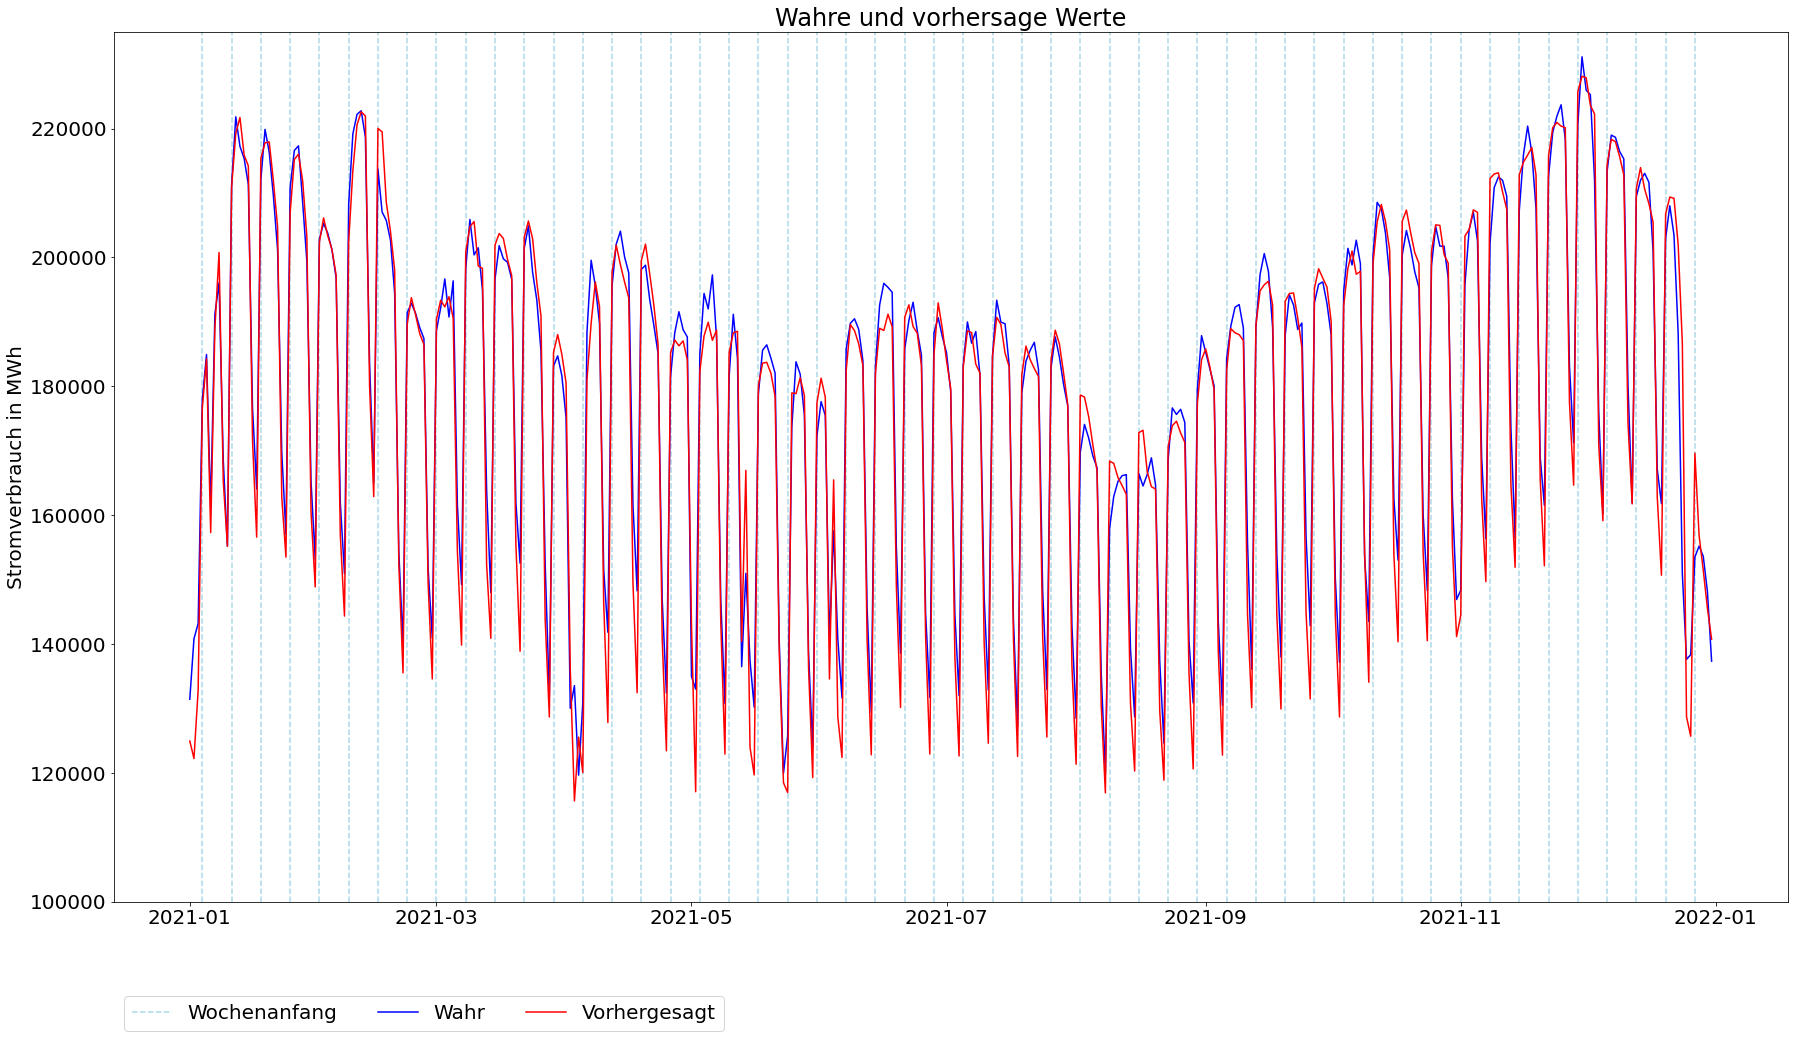

In [7]:
#Vorhersagen erzeugen
scaled_preds_test = model.predict(X_test)
scaled_preds_train = model.predict(X_train)

functions.custom_metrics_lstm(y_test_true, scaled_preds_test, y_train_true, scaled_preds_train)

## <font size="7">LSTM-LSTM-4</font><a class="anchor" id="lstm-lstm-4"></a>

<font size="5">Da das Netz durch die zwei LSTM-Schichten und deren ausgerollten Zeitschichten mittlerweile etwas tiefer geworden ist, wird zu Sicherheit noch einmal überprüft, in wie weit sich das Modell mittels ReLu verbessern lässt.<font>

### <font size="5">Modell und Parameter</font>

In [2]:
#Hyperparameter
epochs = 100
batch_size = 8

window_size = 14

def model_creation():
    
    #Modell erstellen
    model = Sequential()
    model.add(InputLayer(input_shape=(window_size, 4)))
    
    model.add(LSTM(units=32, return_sequences=True, activation="relu"))
    model.add(LSTM(units=64, return_sequences=False, activation="relu"))
    
    model.add(Dense(units=1))

    adam = Adam(learning_rate=0.0005)

    model.compile(loss=root_mean_squared_error, optimizer=adam)
    
    return model

### <font size="5">Daten laden</font>

In [3]:
#Unskalierte Daten für Analysen laden
df_unscaled = pd.read_csv("../3-Data Preparation/data.csv", index_col=0, parse_dates=True)
df_unscaled.index.freq = "D"

y_test_true = df_unscaled["verbrauch"]["2021-01-01":]
y_train_true = df_unscaled["verbrauch"][window_size:2192]

#Skalierte Daten für Modellierung laden
df_scaled = pd.read_csv("../3-Data Preparation/data_scaled.csv", index_col=0, parse_dates=True)
df_scaled.index.freq = "D"

#Aufteilung X (Merkmale) und y (Ziel)
X = df_scaled[["verbrauch","arbeitstag","temperatur","tagesstunden"]]
#Stromverbrauch wird bei X um eine Stelle nach vorne verschoben, daher entfällt der 01.01.2015
X["arbeitstag"] = X["arbeitstag"].shift(-1)
X["temperatur"] = X["temperatur"].shift(-1)
X["tagesstunden"] = X["tagesstunden"].shift(-1)
X = X[:2556]

y = df_scaled["verbrauch"]

#Aufteilung der Daten in Zeitfenster
def restructure_data(px, py, window_size):
    
    X_, y_ = [], []
    
    idx_range = range(len(px) - (window_size) + 1)
    
    for idx in idx_range:
        X_.append(px[idx:idx+window_size])
        y_.append(py[idx+window_size])
        
    X_ = np.array(X_)
    y_ = np.array(y_)
    
    return X_, y_

X_windows, y_windows = restructure_data(X, y, window_size)

#Aufteilung in Trainings-, Validierungs- und Testdaten
split_by = 2557 - 365 - window_size

X_train = X_windows[:split_by]
y_train = y_windows[:split_by]

X_test = X_windows[split_by:]
y_test = y_windows[split_by:]

### <font size="5">Training</font>

In [4]:
#Kreuzvalidierung erstellen
kfold = KFold(n_splits=5, shuffle=True, random_state=0)

#DataFrames für History und Metriken
df_history = pd.DataFrame()
df_history.index.name = "Epoch"

df_metrics = pd.DataFrame(columns=["Testdaten", "Trainingsdaten", "Validierungsdaten"])
df_metrics.index.name = "Split"

iteration = 1

scaler_target = joblib.load("../3-Data Preparation/scaler_endog.save")

#Kreuzvalidierung
for train_index, validation_index in kfold.split(X_train, y_train):
    
    print(iteration, "-", end="\t")
    
    #Modell erstellen
    model = model_creation()
    
    #Modell trainieren
    history = model.fit(x=X_train[train_index], y=y_train[train_index], epochs=epochs, batch_size=batch_size, validation_data=(X_train[validation_index], y_train[validation_index]), verbose=0)
    
    #Ergebnisse speichern
    df_history[str(iteration) + "_train_loss"] = pd.DataFrame(data=(scaler_target.inverse_transform(np.array(history.history["loss"]).reshape(-1, 1)) - 102469)).squeeze()
    df_history[str(iteration) + "_validation_loss"] = pd.DataFrame(data=(scaler_target.inverse_transform(np.array(history.history["val_loss"]).reshape(-1, 1)) - 102469)).squeeze()
    
    #Vorhersagen für Test-, Trainings- und Validierungsdaten
    preds_test = scaler_target.inverse_transform(model.predict(X_test).reshape(-1, 1))
    preds_train = scaler_target.inverse_transform(model.predict(X_train[train_index]).reshape(-1, 1))
    preds_validation = scaler_target.inverse_transform(model.predict(X_train[validation_index]).reshape(-1, 1))
    
    df_metrics.loc[iteration] = [round(metrics.mean_absolute_percentage_error(y_test_true, preds_test) * 100, 2),
                                 round(metrics.mean_absolute_percentage_error(y_train_true[train_index], preds_train) * 100, 2),
                                 round(metrics.mean_absolute_percentage_error(y_train_true[validation_index], preds_validation) * 100, 2)]
    
    iteration = iteration + 1

#Durchschnittswerte bei History und Metriken berechnen
df_history["train_loss"] = (df_history["1_train_loss"] + df_history["2_train_loss"] + df_history["3_train_loss"] + df_history["4_train_loss"] + df_history["5_train_loss"]) / 5
df_history["validation_loss"] = (df_history["1_validation_loss"] + df_history["2_validation_loss"] + df_history["3_validation_loss"] + df_history["4_validation_loss"] + df_history["5_validation_loss"]) / 5

df_metrics.loc["Average"] = [round(df_metrics["Testdaten"].mean(), 2),
                             round(df_metrics["Trainingsdaten"].mean(), 2),
                             round(df_metrics["Validierungsdaten"].mean(), 2)]

1 -	2 -	3 -	4 -	5 -	

### <font size="5">Auswertung des Trainings</font>

         Testdaten  Trainingsdaten  Validierungsdaten
Split                                                
1             2.04            1.40               1.61
2             2.73            1.74               1.87
3             1.96            1.45               1.65
4             2.84            1.75               2.03
5             2.09            1.60               1.75
Average       2.33            1.59               1.78





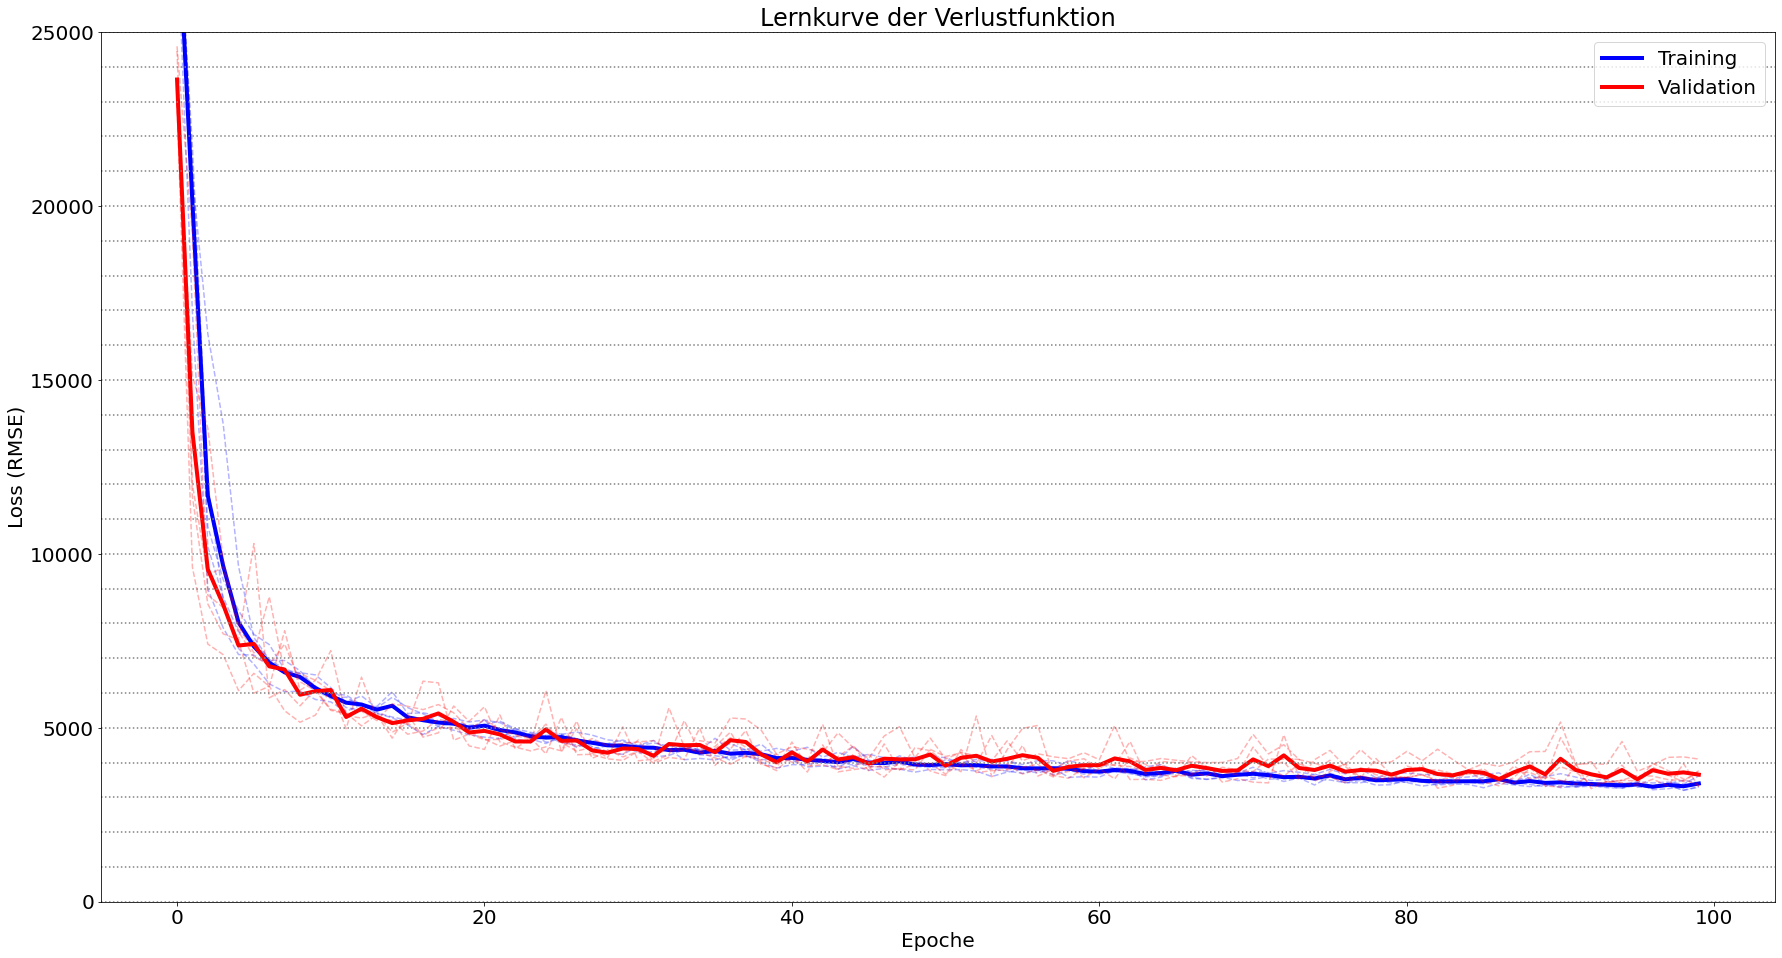

In [5]:
#Training auswerten (Metriken und Lernkurve)
functions.evaluate_training(df_metrics, df_history, 25000)

<font size="5">
Die ReLu führt allerdings zu einer Überanpassung an die Trainingsdaten. Auf den Trainingsdaten lässt sich der MAPE senken, allerdings steigt er auf den Testdaten leicht an.
</font>

### <font size="5">Test</font>

In [8]:
#Finales Modell erstellen
model = model_creation()

#Finales Modell trainieren
history = model.fit(x=X_train, y=y_train, epochs=epochs, batch_size=batch_size, use_multiprocessing=True)

Epoch 1/100
273/273 [==============================] - 3s 6ms/step - loss: 0.2104
Epoch 2/100
273/273 [==============================] - 2s 6ms/step - loss: 0.1582
Epoch 3/100
273/273 [==============================] - 2s 7ms/step - loss: 0.0752
Epoch 4/100
273/273 [==============================] - 2s 6ms/step - loss: 0.0594
Epoch 5/100
273/273 [==============================] - 2s 6ms/step - loss: 0.0539
Epoch 6/100
273/273 [==============================] - 2s 6ms/step - loss: 0.0499
Epoch 7/100
273/273 [==============================] - 2s 6ms/step - loss: 0.0491
Epoch 8/100
273/273 [==============================] - 2s 6ms/step - loss: 0.0454
Epoch 9/100
273/273 [==============================] - 2s 6ms/step - loss: 0.0440
Epoch 10/100
273/273 [==============================] - 2s 6ms/step - loss: 0.0436
Epoch 11/100
273/273 [==============================] - 2s 6ms/step - loss: 0.0417
Epoch 12/100
273/273 [==============================] - 2s 6ms/step - loss: 0.0422
Epoch 13/100


       Testdaten Trainingsdaten
R2          0.95           0.98
MAE       4525.0         2909.0
MSE   32740926.0     14199486.0
RMSE      5722.0         3768.0
                               
MAPE      2.69 %         1.74 %


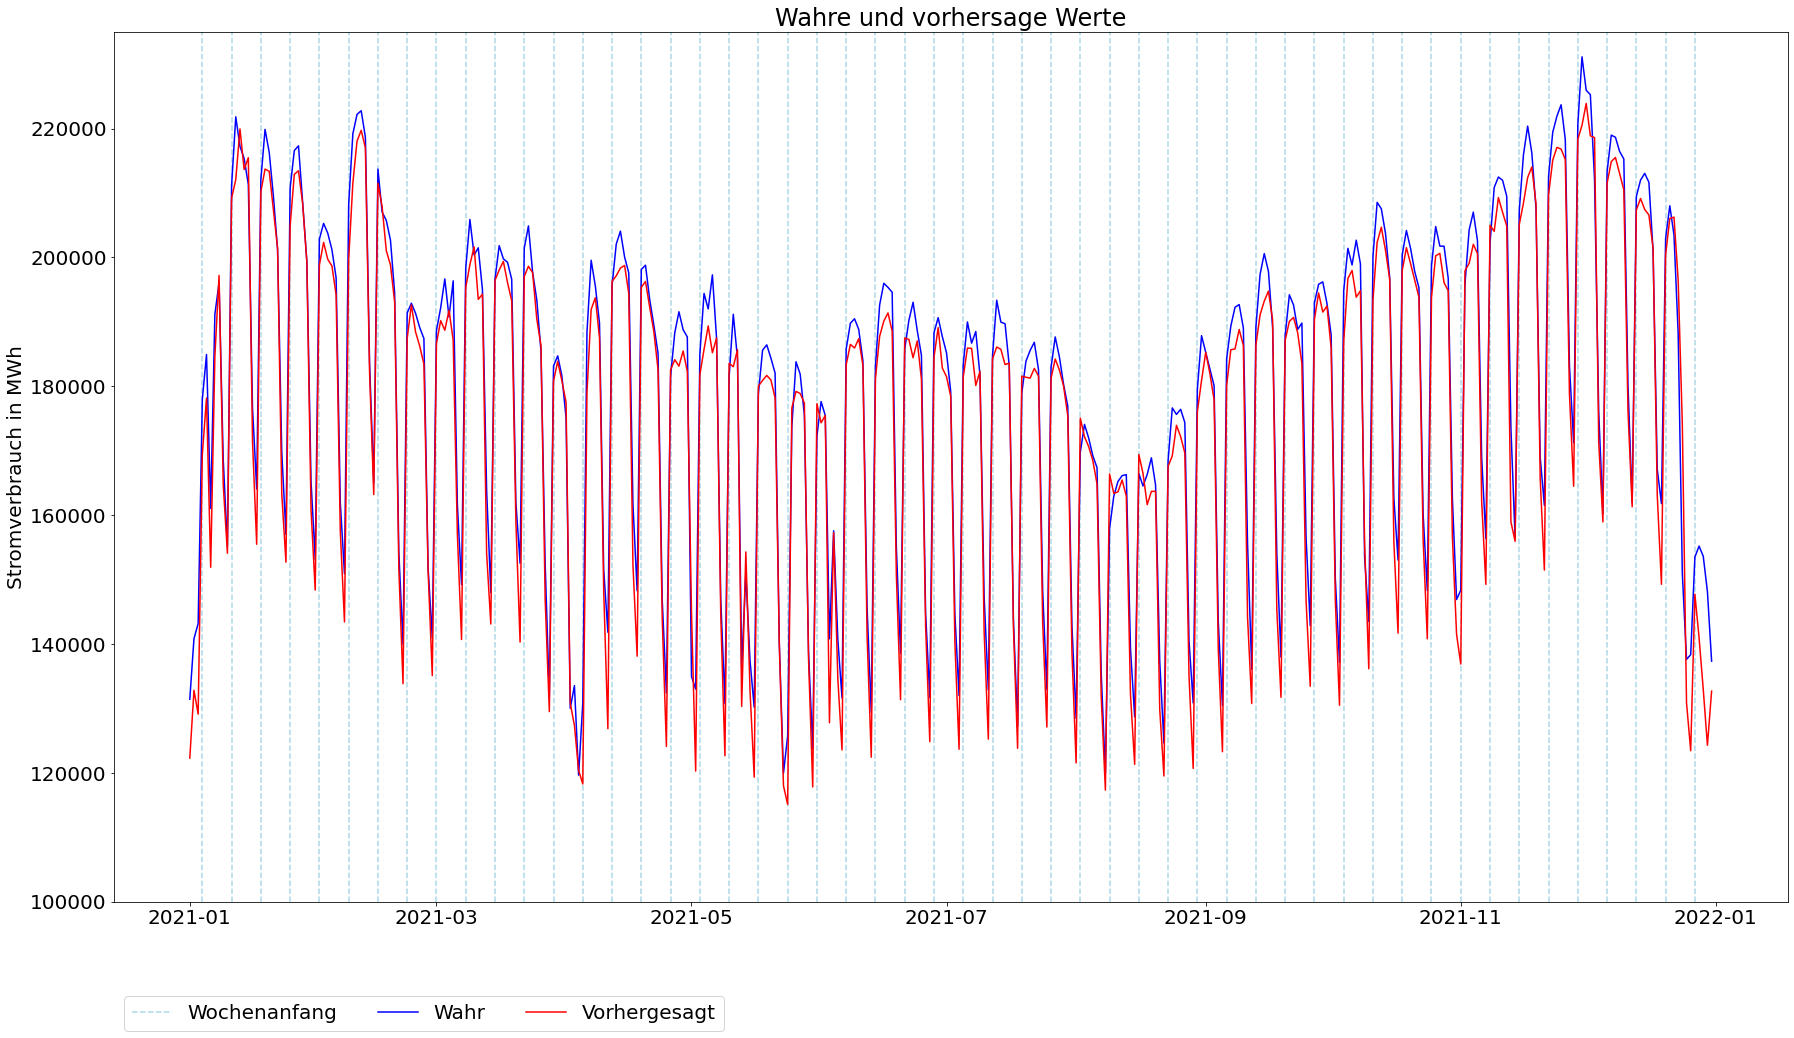

In [9]:
#Vorhersagen erzeugen
scaled_preds_test = model.predict(X_test)
scaled_preds_train = model.predict(X_train)

functions.custom_metrics_lstm(y_test_true, scaled_preds_test, y_train_true, scaled_preds_train)

## <font size="7">LSTM-LSTM-5</font><a class="anchor" id="lstm-lstm-5"></a>

<font size="5">Um sicherzustellen, dass die Verlustfunktion nicht in einem lokalen Minimum hängen bleibt, wird der Training noch einmal mit größeren Batches durchgeführt.<font>

### <font size="5">Modell und Parameter</font>

In [2]:
#Hyperparameter
epochs = 100
batch_size = 16

window_size = 14

def model_creation():
    
    #Modell erstellen
    model = Sequential()
    model.add(InputLayer(input_shape=(window_size, 4)))
    
    model.add(LSTM(units=32, return_sequences=True, activation="tanh"))
    model.add(LSTM(units=64, return_sequences=False, activation="tanh"))
    
    model.add(Dense(units=1))

    adam = Adam(learning_rate=0.0005)

    model.compile(loss=root_mean_squared_error, optimizer=adam)
    
    return model

### <font size="5">Daten laden</font>

In [3]:
#Unskalierte Daten für Analysen laden
df_unscaled = pd.read_csv("../3-Data Preparation/data.csv", index_col=0, parse_dates=True)
df_unscaled.index.freq = "D"

y_test_true = df_unscaled["verbrauch"]["2021-01-01":]
y_train_true = df_unscaled["verbrauch"][window_size:2192]

#Skalierte Daten für Modellierung laden
df_scaled = pd.read_csv("../3-Data Preparation/data_scaled.csv", index_col=0, parse_dates=True)
df_scaled.index.freq = "D"

#Aufteilung X (Merkmale) und y (Ziel)
X = df_scaled[["verbrauch","arbeitstag","temperatur","tagesstunden"]]
#Stromverbrauch wird bei X um eine Stelle nach vorne verschoben, daher entfällt der 01.01.2015
X["arbeitstag"] = X["arbeitstag"].shift(-1)
X["temperatur"] = X["temperatur"].shift(-1)
X["tagesstunden"] = X["tagesstunden"].shift(-1)
X = X[:2556]

y = df_scaled["verbrauch"]

#Aufteilung der Daten in Zeitfenster
def restructure_data(px, py, window_size):
    
    X_, y_ = [], []
    
    idx_range = range(len(px) - (window_size) + 1)
    
    for idx in idx_range:
        X_.append(px[idx:idx+window_size])
        y_.append(py[idx+window_size])
        
    X_ = np.array(X_)
    y_ = np.array(y_)
    
    return X_, y_

X_windows, y_windows = restructure_data(X, y, window_size)

#Aufteilung in Trainings-, Validierungs- und Testdaten
split_by = 2557 - 365 - window_size

X_train = X_windows[:split_by]
y_train = y_windows[:split_by]

X_test = X_windows[split_by:]
y_test = y_windows[split_by:]

### <font size="5">Training</font>

In [4]:
#Kreuzvalidierung erstellen
kfold = KFold(n_splits=5, shuffle=True, random_state=0)

#DataFrames für History und Metriken
df_history = pd.DataFrame()
df_history.index.name = "Epoch"

df_metrics = pd.DataFrame(columns=["Testdaten", "Trainingsdaten", "Validierungsdaten"])
df_metrics.index.name = "Split"

iteration = 1

scaler_target = joblib.load("../3-Data Preparation/scaler_endog.save")

#Kreuzvalidierung
for train_index, validation_index in kfold.split(X_train, y_train):
    
    print(iteration, "-", end="\t")
    
    #Modell erstellen
    model = model_creation()
    
    #Modell trainieren
    history = model.fit(x=X_train[train_index], y=y_train[train_index], epochs=epochs, batch_size=batch_size, validation_data=(X_train[validation_index], y_train[validation_index]), verbose=0)
    
    #Ergebnisse speichern
    df_history[str(iteration) + "_train_loss"] = pd.DataFrame(data=(scaler_target.inverse_transform(np.array(history.history["loss"]).reshape(-1, 1)) - 102469)).squeeze()
    df_history[str(iteration) + "_validation_loss"] = pd.DataFrame(data=(scaler_target.inverse_transform(np.array(history.history["val_loss"]).reshape(-1, 1)) - 102469)).squeeze()
    
    #Vorhersagen für Test-, Trainings- und Validierungsdaten
    preds_test = scaler_target.inverse_transform(model.predict(X_test).reshape(-1, 1))
    preds_train = scaler_target.inverse_transform(model.predict(X_train[train_index]).reshape(-1, 1))
    preds_validation = scaler_target.inverse_transform(model.predict(X_train[validation_index]).reshape(-1, 1))
    
    df_metrics.loc[iteration] = [round(metrics.mean_absolute_percentage_error(y_test_true, preds_test) * 100, 2),
                                 round(metrics.mean_absolute_percentage_error(y_train_true[train_index], preds_train) * 100, 2),
                                 round(metrics.mean_absolute_percentage_error(y_train_true[validation_index], preds_validation) * 100, 2)]
    
    iteration = iteration + 1

#Durchschnittswerte bei History und Metriken berechnen
df_history["train_loss"] = (df_history["1_train_loss"] + df_history["2_train_loss"] + df_history["3_train_loss"] + df_history["4_train_loss"] + df_history["5_train_loss"]) / 5
df_history["validation_loss"] = (df_history["1_validation_loss"] + df_history["2_validation_loss"] + df_history["3_validation_loss"] + df_history["4_validation_loss"] + df_history["5_validation_loss"]) / 5

df_metrics.loc["Average"] = [round(df_metrics["Testdaten"].mean(), 2),
                             round(df_metrics["Trainingsdaten"].mean(), 2),
                             round(df_metrics["Validierungsdaten"].mean(), 2)]

1 -	2 -	3 -	4 -	5 -	

### <font size="5">Auswertung des Trainings</font>

         Testdaten  Trainingsdaten  Validierungsdaten
Split                                                
1             2.35            1.64               1.80
2             2.59            1.65               1.78
3             2.57            1.78               1.83
4             2.57            1.76               2.02
5             2.21            1.64               1.69
Average       2.46            1.69               1.82





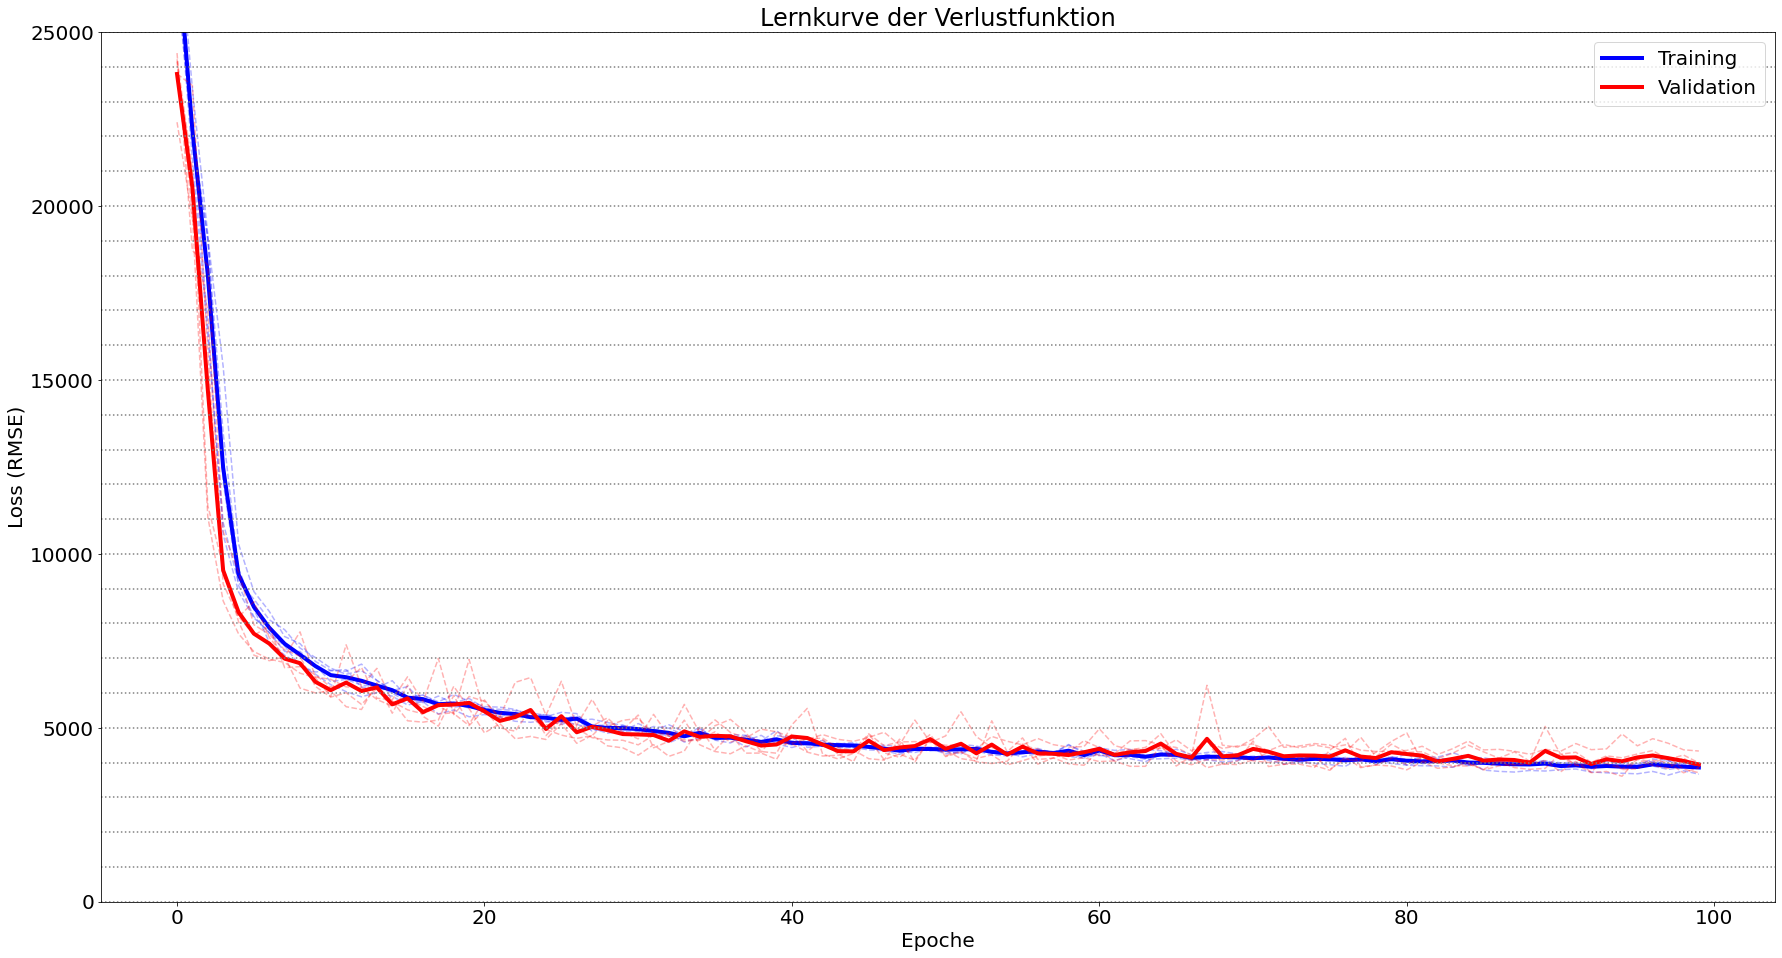

In [5]:
#Training auswerten (Metriken und Lernkurve)
functions.evaluate_training(df_metrics, df_history, 25000)

<font size="5">
Die größeren Batches führen allerdings zu einem Abfall der Qualität der Vorhersagen während der Kreuzvalidierung. Beim finalen Test schneidet das Modell in etwa gleich ab, eine Verbesserung ist hierdurch aber nicht zu erzielen. Viel kleiner sollten die Batches allerdings auch nicht gemacht werden, da das Training an ansonsten sehr lange dauert und nicht davon auszugehen ist, dass die Verlustfunktion das ihr Minimum dadurch besser erreichen kann. Die Batchgröße ist also angemessen.
</font>


### <font size="5">Test</font>

In [6]:
#Finales Modell erstellen
model = model_creation()

#Finales Modell trainieren
history = model.fit(x=X_train, y=y_train, epochs=epochs, batch_size=batch_size, use_multiprocessing=True)

Epoch 1/100
137/137 [==============================] - 4s 8ms/step - loss: 0.2038
Epoch 2/100
137/137 [==============================] - 1s 8ms/step - loss: 0.1643
Epoch 3/100
137/137 [==============================] - 1s 8ms/step - loss: 0.1030
Epoch 4/100
137/137 [==============================] - 1s 8ms/step - loss: 0.0745
Epoch 5/100
137/137 [==============================] - 1s 8ms/step - loss: 0.0623
Epoch 6/100
137/137 [==============================] - 1s 9ms/step - loss: 0.0559
Epoch 7/100
137/137 [==============================] - 1s 9ms/step - loss: 0.0521
Epoch 8/100
137/137 [==============================] - 1s 8ms/step - loss: 0.0508
Epoch 9/100
137/137 [==============================] - 1s 9ms/step - loss: 0.0487
Epoch 10/100
137/137 [==============================] - 1s 8ms/step - loss: 0.0466
Epoch 11/100
137/137 [==============================] - 1s 8ms/step - loss: 0.0471
Epoch 12/100
137/137 [==============================] - 1s 8ms/step - loss: 0.0461
Epoch 13/100


       Testdaten Trainingsdaten
R2          0.96           0.98
MAE       4214.0         2878.0
MSE   31126323.0     15189041.0
RMSE      5579.0         3897.0
                               
MAPE      2.58 %         1.77 %


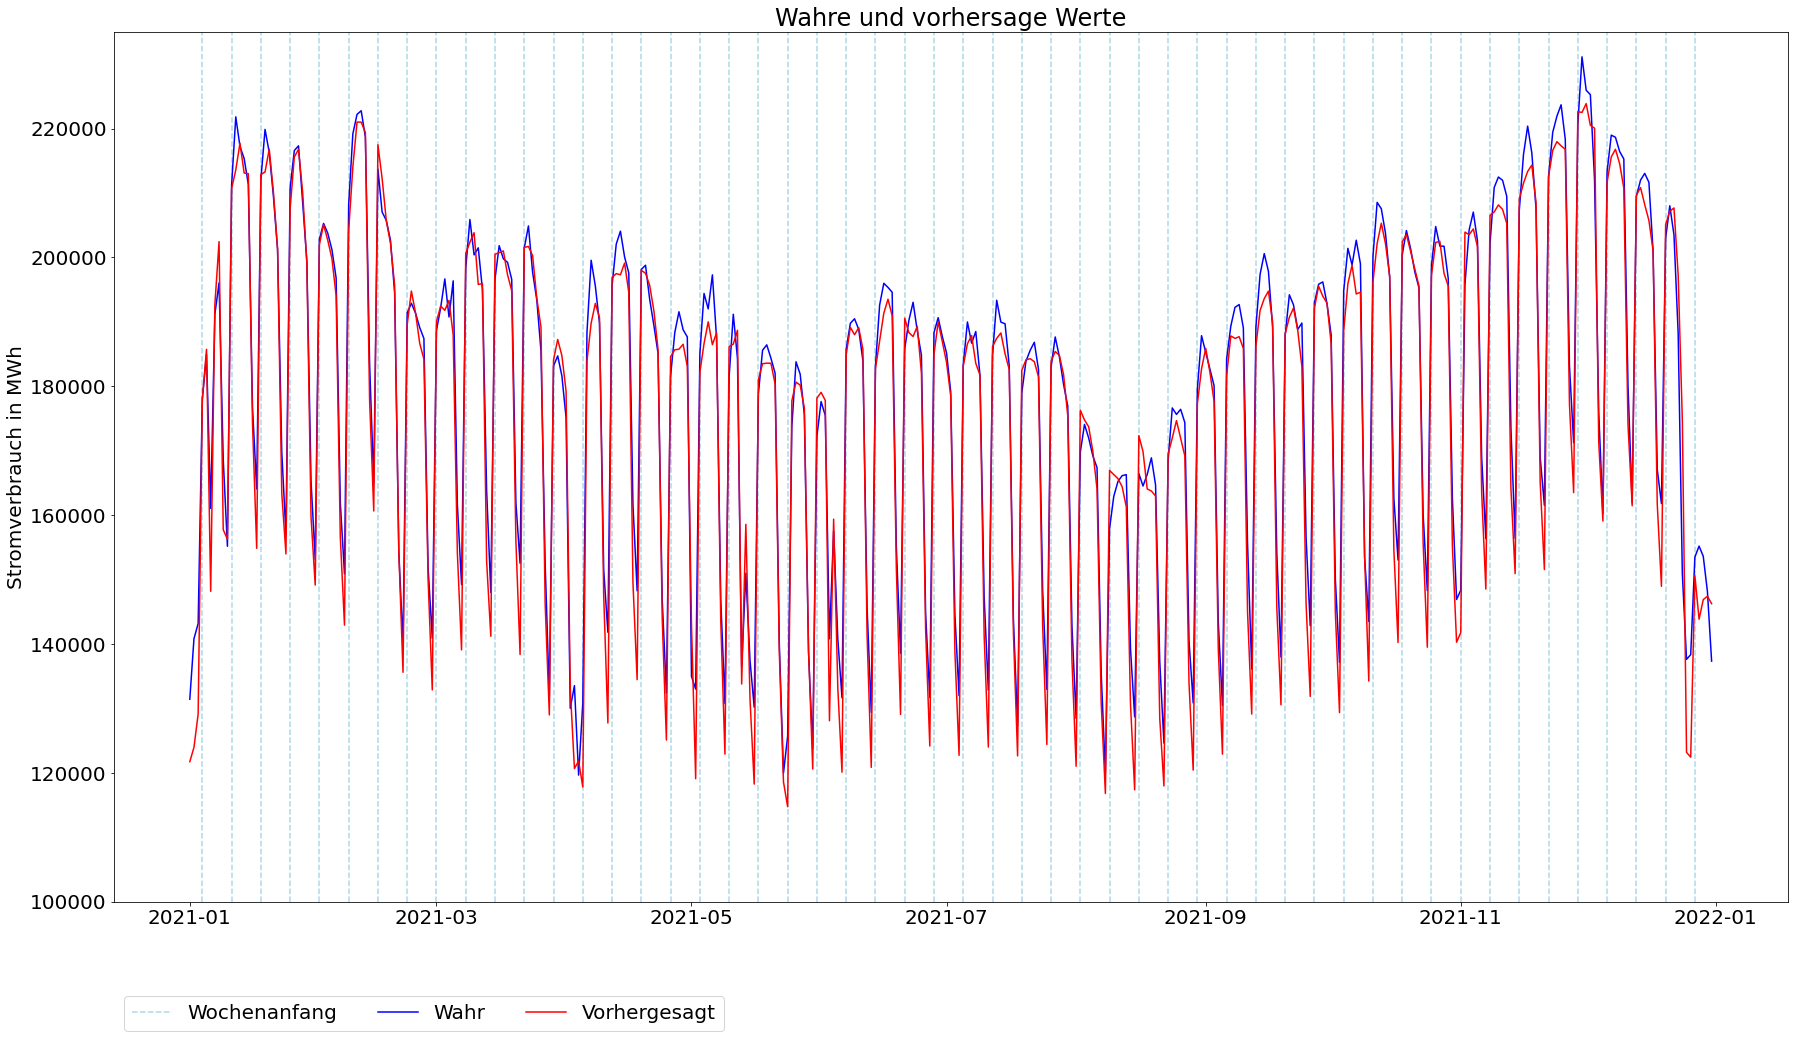

In [7]:
#Vorhersagen erzeugen
scaled_preds_test = model.predict(X_test)
scaled_preds_train = model.predict(X_train)

functions.custom_metrics_lstm(y_test_true, scaled_preds_test, y_train_true, scaled_preds_train)

## <font size="7">LSTM-LSTM-6</font><a class="anchor" id="lstm-lstm-6"></a>

<font size="5">Die bisher probierten Architekturen und Trainingsparameter führen nicht zu ausreichenden Ergebnissen. Letztlich soll allerdings noch ein Netz mit mehr Neuronen ausprobiert werden. Dafür werden 128 Neuronen in beiden Schichten eingefügt.<font>

### <font size="5">Modell und Parameter</font>

In [2]:
#Hyperparameter
epochs = 100
batch_size = 8

window_size = 14

def model_creation():
    
    #Modell erstellen
    model = Sequential()
    model.add(InputLayer(input_shape=(window_size, 4)))
    
    model.add(LSTM(units=128, return_sequences=True, activation="tanh"))
    model.add(LSTM(units=128, return_sequences=False, activation="tanh"))
    
    model.add(Dense(units=1))

    adam = Adam(learning_rate=0.0005)

    model.compile(loss=root_mean_squared_error, optimizer=adam)
    
    return model

### <font size="5">Daten laden</font>

In [3]:
#Unskalierte Daten für Analysen laden
df_unscaled = pd.read_csv("../3-Data Preparation/data.csv", index_col=0, parse_dates=True)
df_unscaled.index.freq = "D"

y_test_true = df_unscaled["verbrauch"]["2021-01-01":]
y_train_true = df_unscaled["verbrauch"][window_size:2192]

#Skalierte Daten für Modellierung laden
df_scaled = pd.read_csv("../3-Data Preparation/data_scaled.csv", index_col=0, parse_dates=True)
df_scaled.index.freq = "D"

#Aufteilung X (Merkmale) und y (Ziel)
X = df_scaled[["verbrauch","arbeitstag","temperatur","tagesstunden"]]
#Stromverbrauch wird bei X um eine Stelle nach vorne verschoben, daher entfällt der 01.01.2015
X["arbeitstag"] = X["arbeitstag"].shift(-1)
X["temperatur"] = X["temperatur"].shift(-1)
X["tagesstunden"] = X["tagesstunden"].shift(-1)
X = X[:2556]

y = df_scaled["verbrauch"]

#Aufteilung der Daten in Zeitfenster
def restructure_data(px, py, window_size):
    
    X_, y_ = [], []
    
    idx_range = range(len(px) - (window_size) + 1)
    
    for idx in idx_range:
        X_.append(px[idx:idx+window_size])
        y_.append(py[idx+window_size])
        
    X_ = np.array(X_)
    y_ = np.array(y_)
    
    return X_, y_

X_windows, y_windows = restructure_data(X, y, window_size)

#Aufteilung in Trainings-, Validierungs- und Testdaten
split_by = 2557 - 365 - window_size

X_train = X_windows[:split_by]
y_train = y_windows[:split_by]

X_test = X_windows[split_by:]
y_test = y_windows[split_by:]

### <font size="5">Training</font>

In [4]:
#Kreuzvalidierung erstellen
kfold = KFold(n_splits=5, shuffle=True, random_state=0)

#DataFrames für History und Metriken
df_history = pd.DataFrame()
df_history.index.name = "Epoch"

df_metrics = pd.DataFrame(columns=["Testdaten", "Trainingsdaten", "Validierungsdaten"])
df_metrics.index.name = "Split"

iteration = 1

scaler_target = joblib.load("../3-Data Preparation/scaler_endog.save")

#Kreuzvalidierung
for train_index, validation_index in kfold.split(X_train, y_train):
    
    print(iteration, "-", end="\t")
    
    #Modell erstellen
    model = model_creation()
    
    #Modell trainieren
    history = model.fit(x=X_train[train_index], y=y_train[train_index], epochs=epochs, batch_size=batch_size, validation_data=(X_train[validation_index], y_train[validation_index]), verbose=0)
    
    #Ergebnisse speichern
    df_history[str(iteration) + "_train_loss"] = pd.DataFrame(data=(scaler_target.inverse_transform(np.array(history.history["loss"]).reshape(-1, 1)) - 102469)).squeeze()
    df_history[str(iteration) + "_validation_loss"] = pd.DataFrame(data=(scaler_target.inverse_transform(np.array(history.history["val_loss"]).reshape(-1, 1)) - 102469)).squeeze()
    
    #Vorhersagen für Test-, Trainings- und Validierungsdaten
    preds_test = scaler_target.inverse_transform(model.predict(X_test).reshape(-1, 1))
    preds_train = scaler_target.inverse_transform(model.predict(X_train[train_index]).reshape(-1, 1))
    preds_validation = scaler_target.inverse_transform(model.predict(X_train[validation_index]).reshape(-1, 1))
    
    df_metrics.loc[iteration] = [round(metrics.mean_absolute_percentage_error(y_test_true, preds_test) * 100, 2),
                                 round(metrics.mean_absolute_percentage_error(y_train_true[train_index], preds_train) * 100, 2),
                                 round(metrics.mean_absolute_percentage_error(y_train_true[validation_index], preds_validation) * 100, 2)]
    
    iteration = iteration + 1

#Durchschnittswerte bei History und Metriken berechnen
df_history["train_loss"] = (df_history["1_train_loss"] + df_history["2_train_loss"] + df_history["3_train_loss"] + df_history["4_train_loss"] + df_history["5_train_loss"]) / 5
df_history["validation_loss"] = (df_history["1_validation_loss"] + df_history["2_validation_loss"] + df_history["3_validation_loss"] + df_history["4_validation_loss"] + df_history["5_validation_loss"]) / 5

df_metrics.loc["Average"] = [round(df_metrics["Testdaten"].mean(), 2),
                             round(df_metrics["Trainingsdaten"].mean(), 2),
                             round(df_metrics["Validierungsdaten"].mean(), 2)]

1 -	2 -	3 -	4 -	5 -	

### <font size="5">Auswertung des Trainings</font>

         Testdaten  Trainingsdaten  Validierungsdaten
Split                                                
1             2.15            1.35               1.56
2             2.91            1.69               1.87
3             2.53            1.44               1.70
4             2.32            1.38               1.74
5             1.99            1.40               1.60
Average       2.38            1.45               1.69





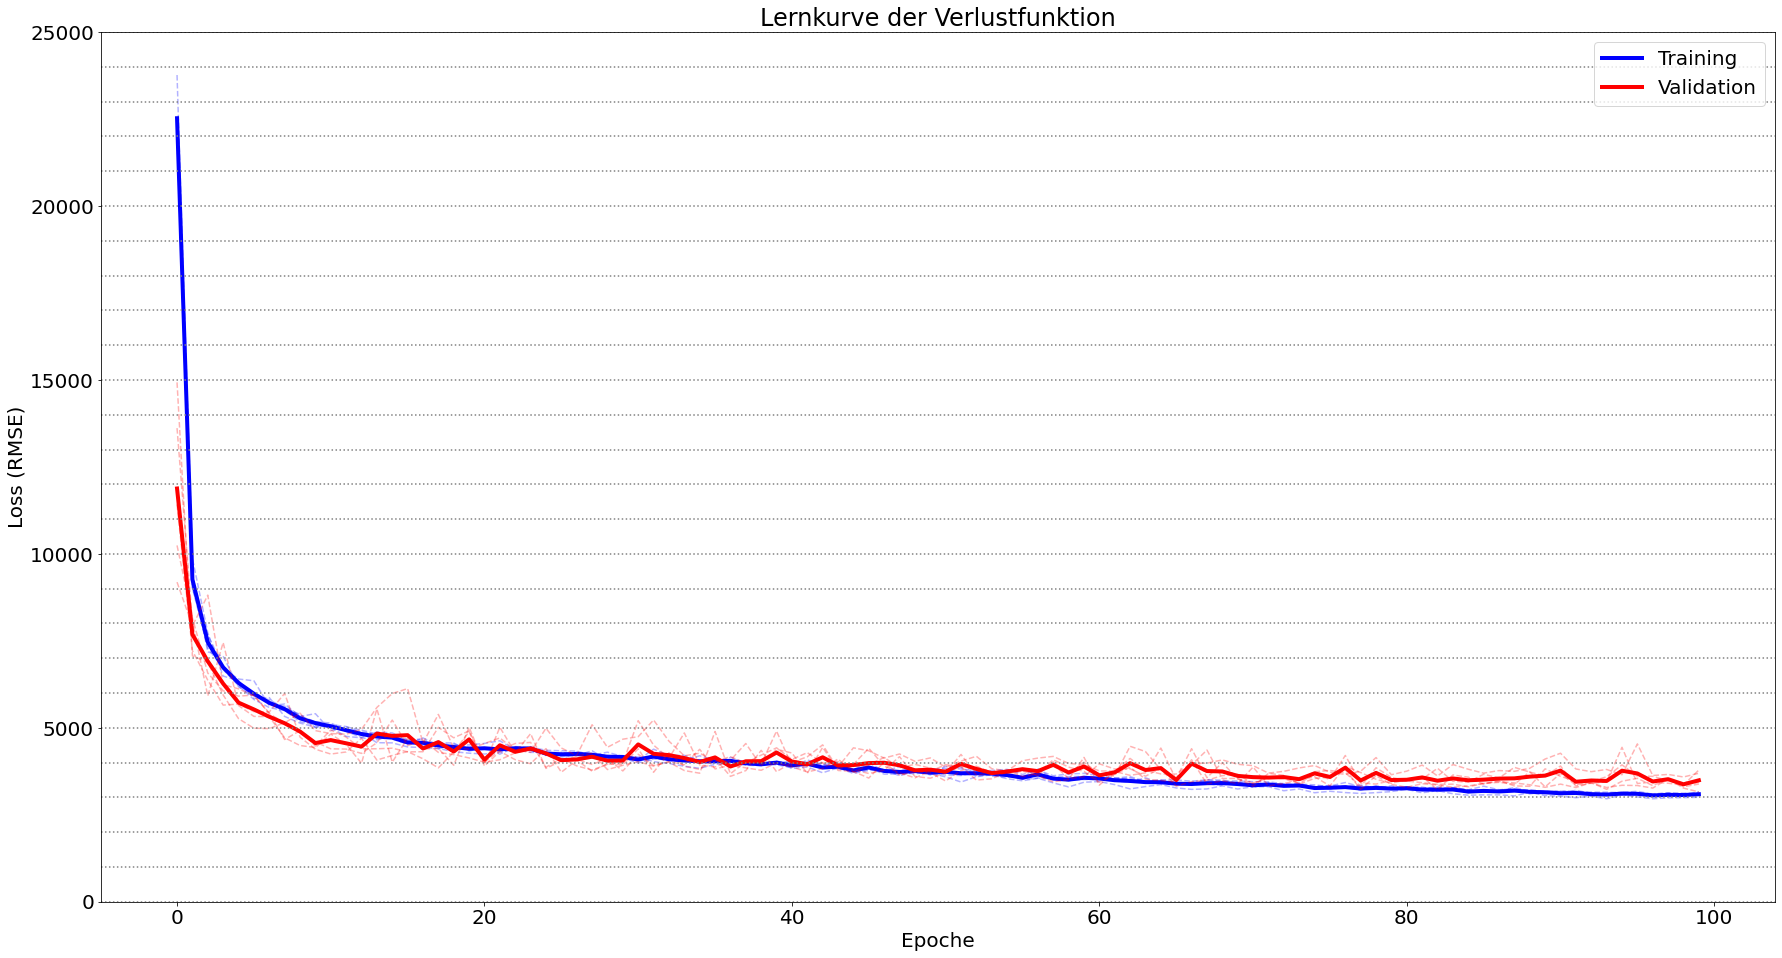

In [5]:
#Training auswerten (Metriken und Lernkurve)
functions.evaluate_training(df_metrics, df_history, 25000)

<font size="5">
Der MAPE wird nicht verbessert (im Vergleich zu LSTM-LSTM-2), obwohl es sich um ein sehr viel umfangreicheres Netz handelt. Es scheint, dass das Potenzial selbst mit kleinen Netzen sehr schnell erschlossen werden kann, mehr Neuronen, Schichten oder ein längeres Training tragen nur wenig zu Verbesserungen bei.
</font>


### <font size="5">Test</font>

In [10]:
#Finales Modell erstellen
model = model_creation()

#Finales Modell trainieren
history = model.fit(x=X_train, y=y_train, epochs=epochs, batch_size=batch_size, use_multiprocessing=True)

Epoch 1/100
273/273 [==============================] - 6s 13ms/step - loss: 0.1525
Epoch 2/100
273/273 [==============================] - 3s 13ms/step - loss: 0.0619
Epoch 3/100
273/273 [==============================] - 4s 14ms/step - loss: 0.0537
Epoch 4/100
273/273 [==============================] - 4s 14ms/step - loss: 0.0474
Epoch 5/100
273/273 [==============================] - 4s 13ms/step - loss: 0.0457
Epoch 6/100
273/273 [==============================] - 3s 13ms/step - loss: 0.0429
Epoch 7/100
273/273 [==============================] - 4s 13ms/step - loss: 0.0413
Epoch 8/100
273/273 [==============================] - 4s 13ms/step - loss: 0.0401
Epoch 9/100
273/273 [==============================] - 3s 13ms/step - loss: 0.0402
Epoch 10/100
273/273 [==============================] - 3s 13ms/step - loss: 0.0383
Epoch 11/100
273/273 [==============================] - 3s 13ms/step - loss: 0.0361
Epoch 12/100
273/273 [==============================] - 3s 13ms/step - loss: 0.0361
E

       Testdaten Trainingsdaten
R2          0.96           0.98
MAE       3904.0         2370.0
MSE   27930955.0     10918003.0
RMSE      5285.0         3304.0
                               
MAPE      2.36 %         1.47 %


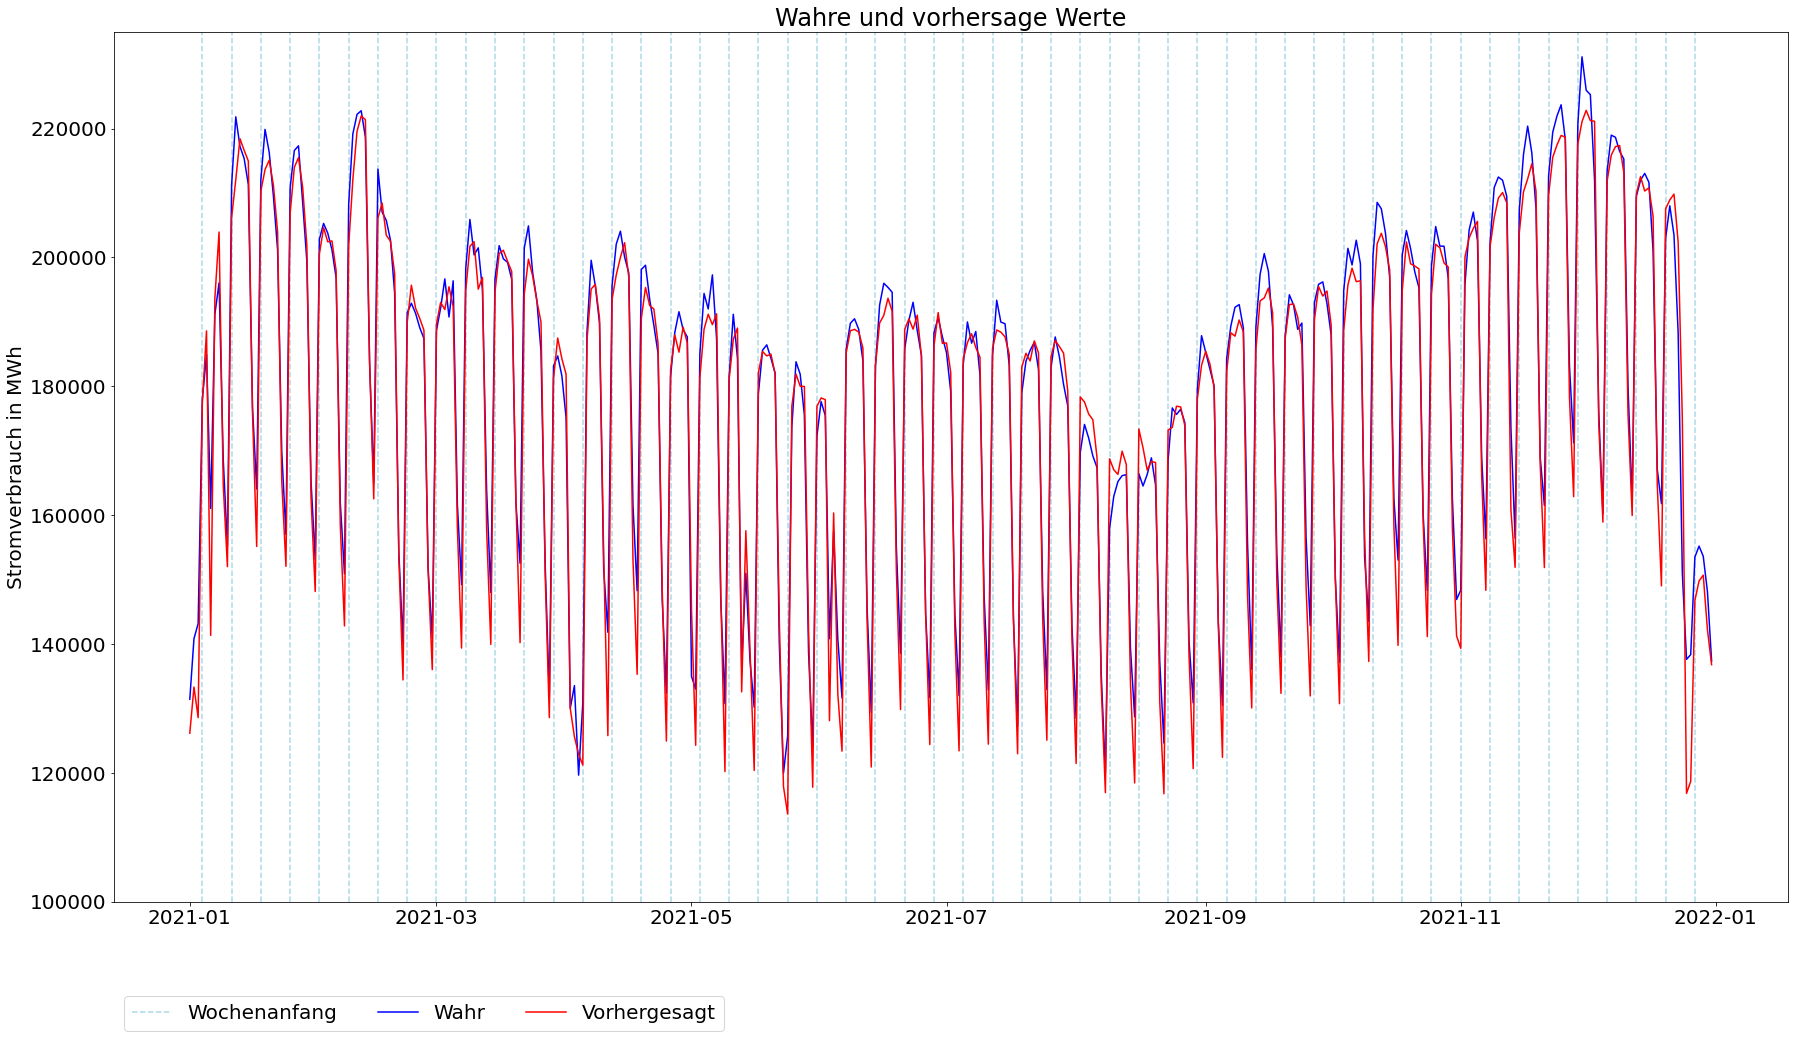

In [11]:
#Vorhersagen erzeugen
scaled_preds_test = model.predict(X_test)
scaled_preds_train = model.predict(X_train)

functions.custom_metrics_lstm(y_test_true, scaled_preds_test, y_train_true, scaled_preds_train)